In [1]:
# env oc pour OpenClassrooms
# context : Projet Nutriscore - "Open Food Facts"

# Partie 1 - Jupiter Notebook
# Partie 2 - Page web: Application
# Partie 3 - Présentation du sujet (diaporama)

# __auteur__ = "Benjamin Schoenmaeker"
# __date__ =  "07-02-2023"

<h1>Projet 3 : Concevoir une application pour "Santé Publique France"</h1>

Les données utilisées dans le cadre de ce projet sont issues du projet Open Food (voir https://world.openfoodfacts.org/).

1 - Présentation du projet (type Power Point)

2 - Notebook : Nettoyage des données

3 - Page web : Application
Constat : 
Le nutri-score sert à aider les consommateurs à trouver des produits plus sains pour mieux manger. 
Solution : 
Créer une application qui permet d’établir une note représentant le caractère nutritionnel d’un produit à l’aide des valeurs renseignées et exploitables de la base de données Open Food.

<h2>1 - Notebook : Nettoyage des données</h2>

Différentes étapes:
- Importation des données
- Bilan de l'importation des données
- Pré-visualisation des valeurs manquantes
- Approche technique
- Pré-visualisation du nouveau jeu de données
    - Valeurs catégorielles
    - Valeurs numériques
- Nettoyage des données basé sur la connaissance métier
    - Valeurs absentes
    - Valeurs catégorielles
    - Valeurs numériques
    - Exemple de traitement métier avec la valeur "fat_100g"
- Nettoyage des données basé sur la connaissance statistique
    - Traitement statistique interquartile
    - Exemple de traitement métier et statistique avec la valeur "salt_100g"
- Comparatif de traitement métier et statistique avec les valeurs du jeu de données
- Analyse des résultats :
    - Analyse uni-variée
        - Valeurs catégorielles
        - Valeurs numériques
    - Analyse bi-variée
    - Analyse multivariée
        - ACP
        - ANOVA
- Exportation des données traitées au format csv pour l'application

In [2]:
# Importation des données
import ipywidgets as widgets
import pandas as pd
import geopandas as gpd

# Calcul
import numpy as np

# Calcul des données érronées
import math
import missingno as msno

# Affichage graphique des données
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Analyse statistique
from sklearn import datasets
from sklearn.cluster import KMeans

from scipy.stats import iqr

# Exportation graphique des données
import os
import dataframe_image as dfi

# Données codes pays
import pycountry
# from unidecode import unidecode

# Initialisation de la taille des graphiques
plt.rcParams["figure.figsize"] = (12,12)
small_size = 6
plt.rcParams.update({'font.size': small_size})

<h3>Importation des données</h3>

In [3]:
# Importation du jeu de données téléchargées
open_food_dataframe = pd.read_csv('data\products.csv', sep='\t', low_memory=False) # index_col=0,

<h3>Bilan de l'importation des données</h3>

In [4]:
# Affichage du nombre de lignes et de colonnes de l'ensemble de données
print('Le jeu de données compte {:,} entrées '.format(open_food_dataframe.shape[0]) + 'réparties dans {} colonnes'.format(open_food_dataframe.shape[1]))

Le jeu de données compte 320,772 entrées réparties dans 162 colonnes


In [5]:
# Affichage du nombre de colonnes de chaque type de données dans l'ensemble de données 
open_food_dataframe.dtypes.value_counts()

float64    106
object      56
dtype: int64

In [6]:
# Récupération des informations du dataframe
open_food_dataframe.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 162 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        320749 non-null  object 
 1    url                                         320749 non-null  object 
 2    creator                                     320770 non-null  object 
 3    created_t                                   320769 non-null  object 
 4    created_datetime                            320763 non-null  object 
 5    last_modified_t                             320772 non-null  object 
 6    last_modified_datetime                      320772 non-null  object 
 7    product_name                                303010 non-null  object 
 8    generic_name                                52795 non-null   object 
 9    quantity                                    104819 non-nu

Lecture de quelques lignes afin de voir les variables disponibles

In [7]:
# Aperçu d'un extrait
open_food_dataframe.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Sauvegarde
# dfi.export(open_food_dataframe.head(),"./export/img/000_dataframe_apercu.png", table_conversion="matplotlib", max_cols=-1)

<h3>Pré-visualisation des valeurs manquantes</h3>

La pré-visualisation des valeurs manquantes est un élément important de la préparation des données pour l'analyse.
Cela permet de comprendre la distribution et la fréquence des valeurs manquantes dans un jeu de données.

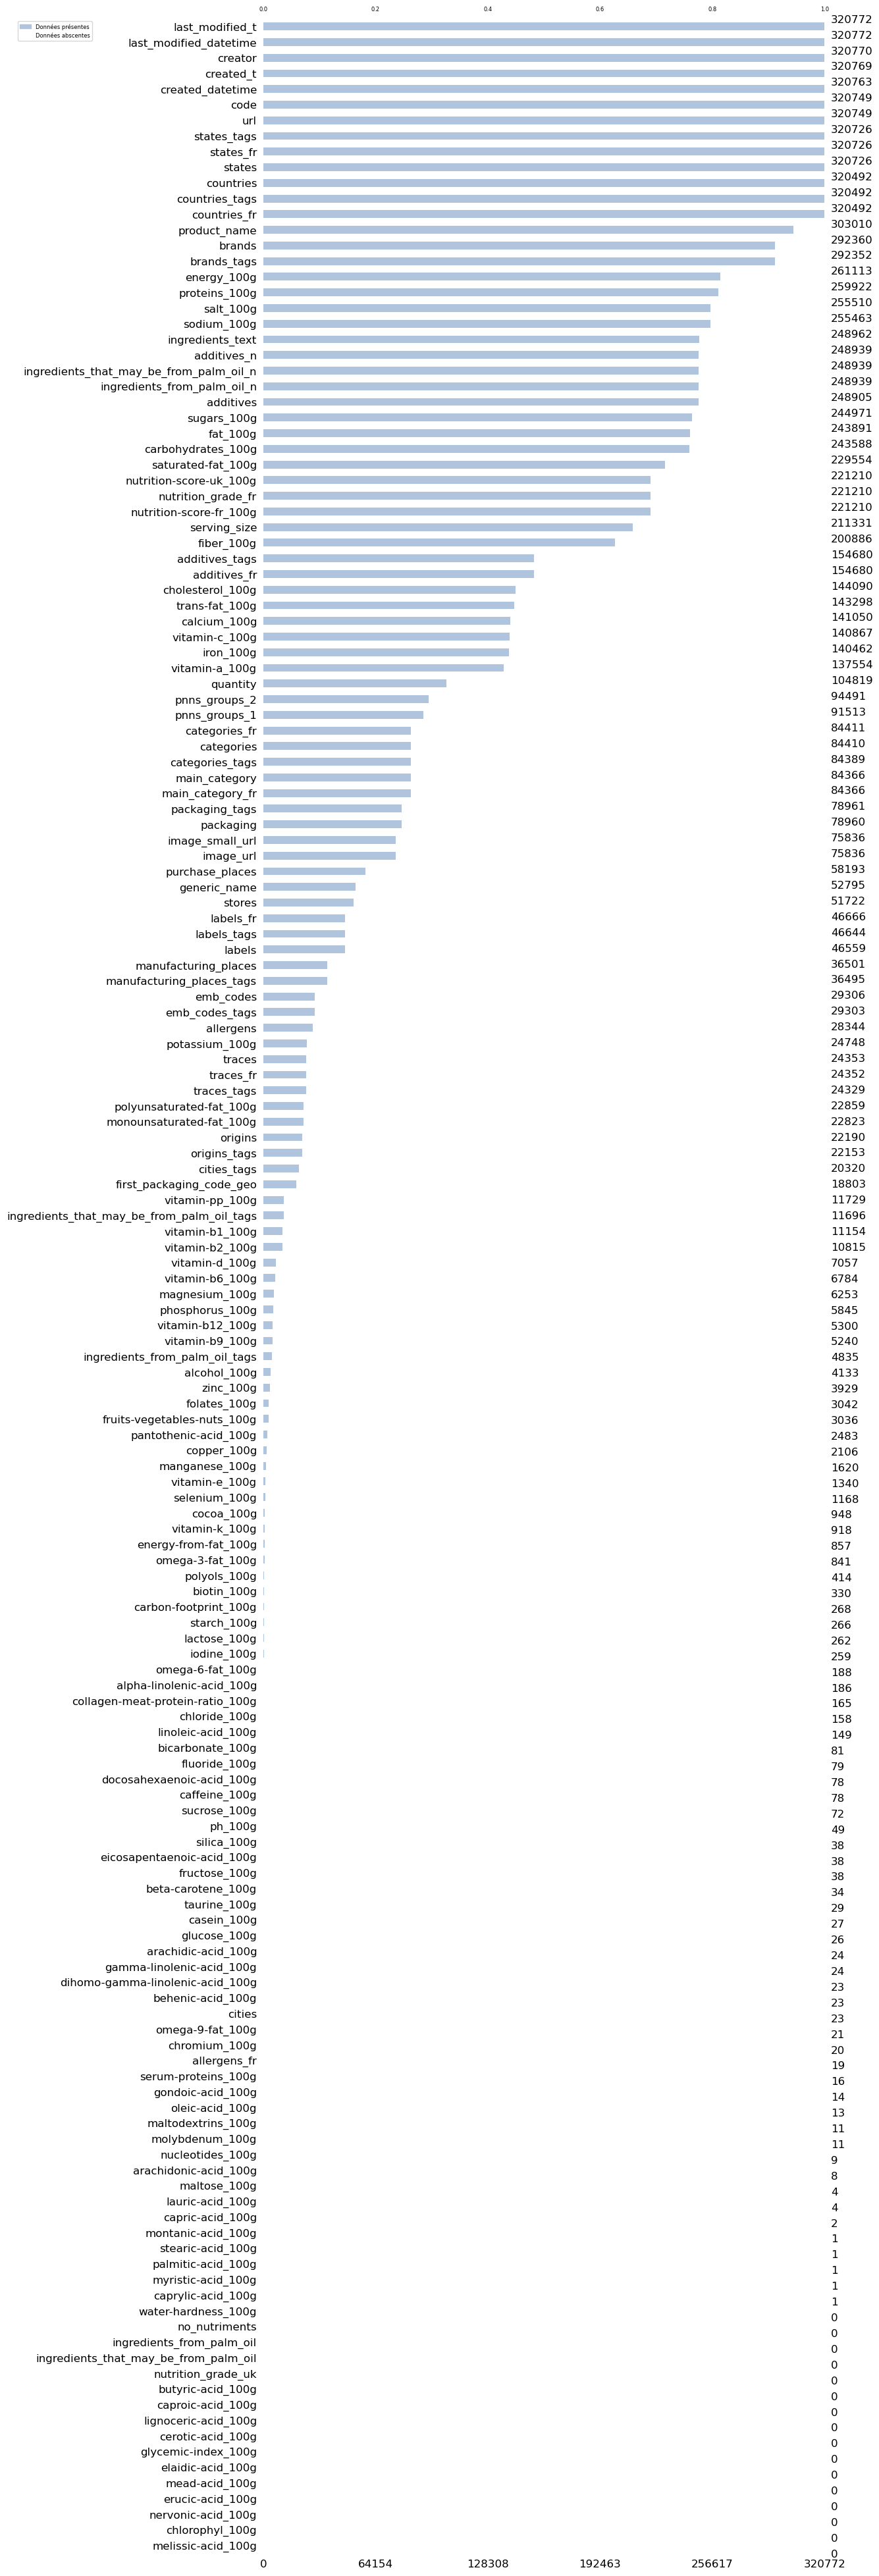

In [9]:
# Création d'un diagramme de barres pour visualiser les données manquantes dans l'ensemble de données open_food_dataframe
msno.bar(open_food_dataframe, color='lightsteelblue', sort="ascending", figsize=(11,50), fontsize=12)

#Création de patch pour les données présentes 
blue_patch = mpatches.Patch(color='lightsteelblue', label='Données présentes')

#Création de patch pour les données absentes
white_patch = mpatches.Patch(color='white', label='Données abscentes')

#Ajout d'une légende à la figure en utilisant les objets Patch créés précédemment
plt.legend(bbox_to_anchor=(-0.30, 1), handles=[blue_patch, white_patch])

# Exportation de l'image des données vides
plt.savefig("./export/img/001_open_food_dataframe_preview.png", dpi=300,bbox_inches='tight')

plt.show()

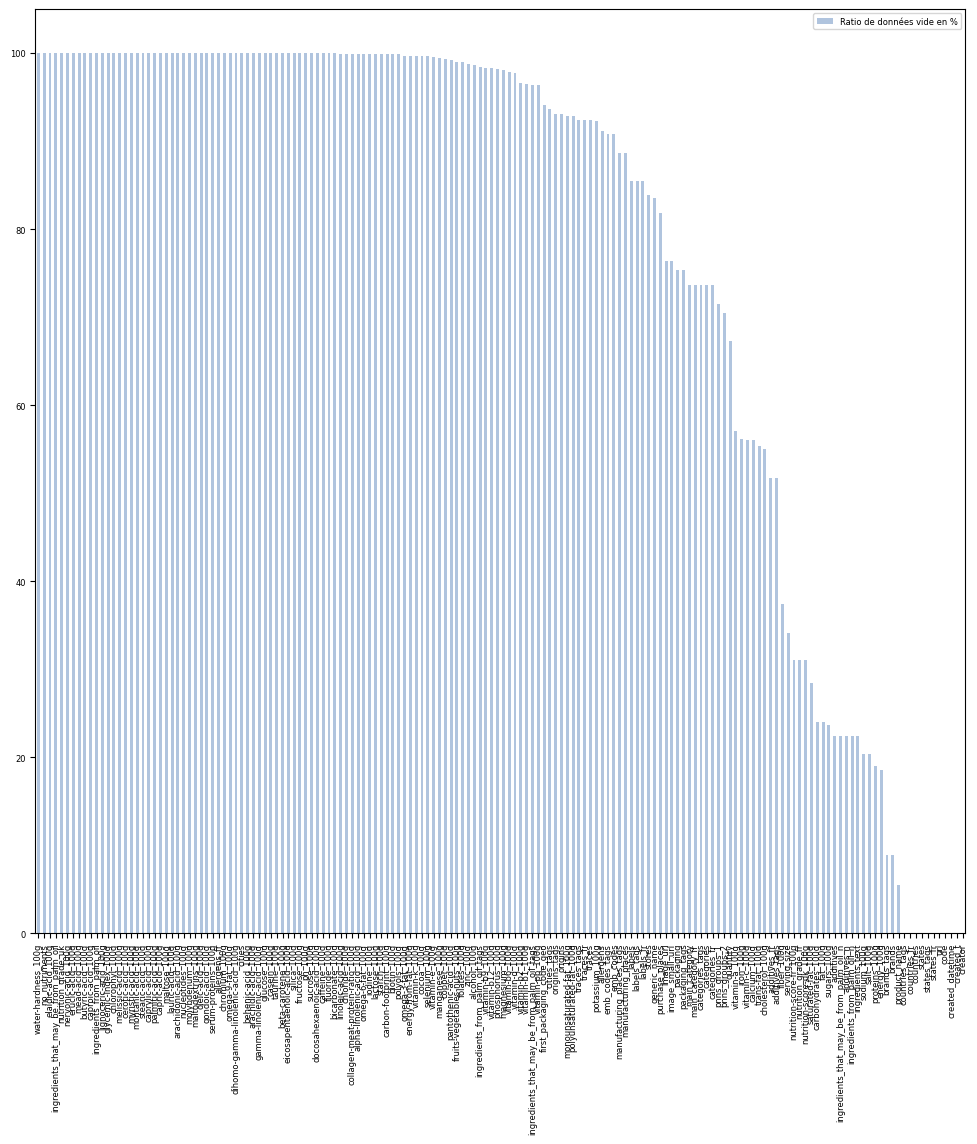

In [10]:
# Mise en valeur des données vides
# Calcul du ratio de données vides pour chaque colonne
not_in_dataframe = (open_food_dataframe.isnull().sum() / len(open_food_dataframe)) * 100 

# Suppression des colonnes sans données vides
not_in_dataframe = not_in_dataframe.drop(not_in_dataframe[not_in_dataframe == 0].index).sort_values(ascending=False)

# Création d'un DataFrame contenant les ratios de données vides pour chaque colonne
missing_data = pd.DataFrame({'Ratio de données vide en %' :not_in_dataframe})

# Création d'un diagramme à barres pour représenter les ratios de données vides
missing_data.plot(kind = "bar", color='lightsteelblue')

# Exportation de l'image des données vides
plt.savefig("./export/img/002_open_food_dataframe_empty_data.png", dpi=300,bbox_inches='tight')

# Affichage du diagramme
plt.show()


<h3>Approche technique</h3>

L'approche technique va servir à distinguer les valeurs à conserver des valeurs inutile pour l'analyse et l'application en vue

In [11]:
# Approche technique de nettoyage des données
# Sauvegarde de la colonne "main_category_fr"
main_category_fr = open_food_dataframe['main_category_fr']
# categories = open_food_dataframe['categories']

# Sélection des colonnes contenant moins de 50 % de données "null" c'est à dire vide
nan_values = open_food_dataframe.isnull().sum()/len(open_food_dataframe)
len(nan_values[nan_values < 0.5])
nan_values = nan_values[nan_values < 0.5]

# Echantillonnage dans un nouveau dataframe "sampling_open_food" et "sampling_open_food_copy"
sampling_open_food = open_food_dataframe[list(nan_values.index)].copy()
# sampling_open_food_copy = open_food_dataframe.copy()

# Ajout de la colonne "main_category_fr" au dataframe
sampling_open_food['main_category_fr'] = main_category_fr
# sampling_open_food['categories'] = categories

# Exportation image aperçu
dfi.export(sampling_open_food.head(),"./export/img/003_sampling_open_food_preview.png", table_conversion="matplotlib", max_cols=-1)
# Affichage
sampling_open_food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,main_category_fr
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0,14.0,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,...,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0,12.0,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,...,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN


In [12]:
# Exportation de l'image
dfi.export(sampling_open_food.head(),'./export/img/004_sampling_open_food_head_preview.png', table_conversion="matplotlib", max_cols=-1)

In [13]:
# Affichage du nombre de lignes et de colonnes de l'ensemble de données
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 320,772 entrées réparties dans 35 colonnes


In [14]:
# Affichage des informations générales sur l'ensemble de données
sampling_open_food.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   url                                      320749 non-null  object 
 2   creator                                  320770 non-null  object 
 3   created_t                                320769 non-null  object 
 4   created_datetime                         320763 non-null  object 
 5   last_modified_t                          320772 non-null  object 
 6   last_modified_datetime                   320772 non-null  object 
 7   product_name                             303010 non-null  object 
 8   brands                                   292360 non-null  object 
 9   brands_tags                              292352 non-null  object 
 10  countries                       

Après une première sélection de colonnes la création d'un diagramme de matrice de données manquantes permet de visualiser graphiquement les patterns et les tendances dans les données manquantes pour une sélection de colonnes spécifique dans un jeu de données.

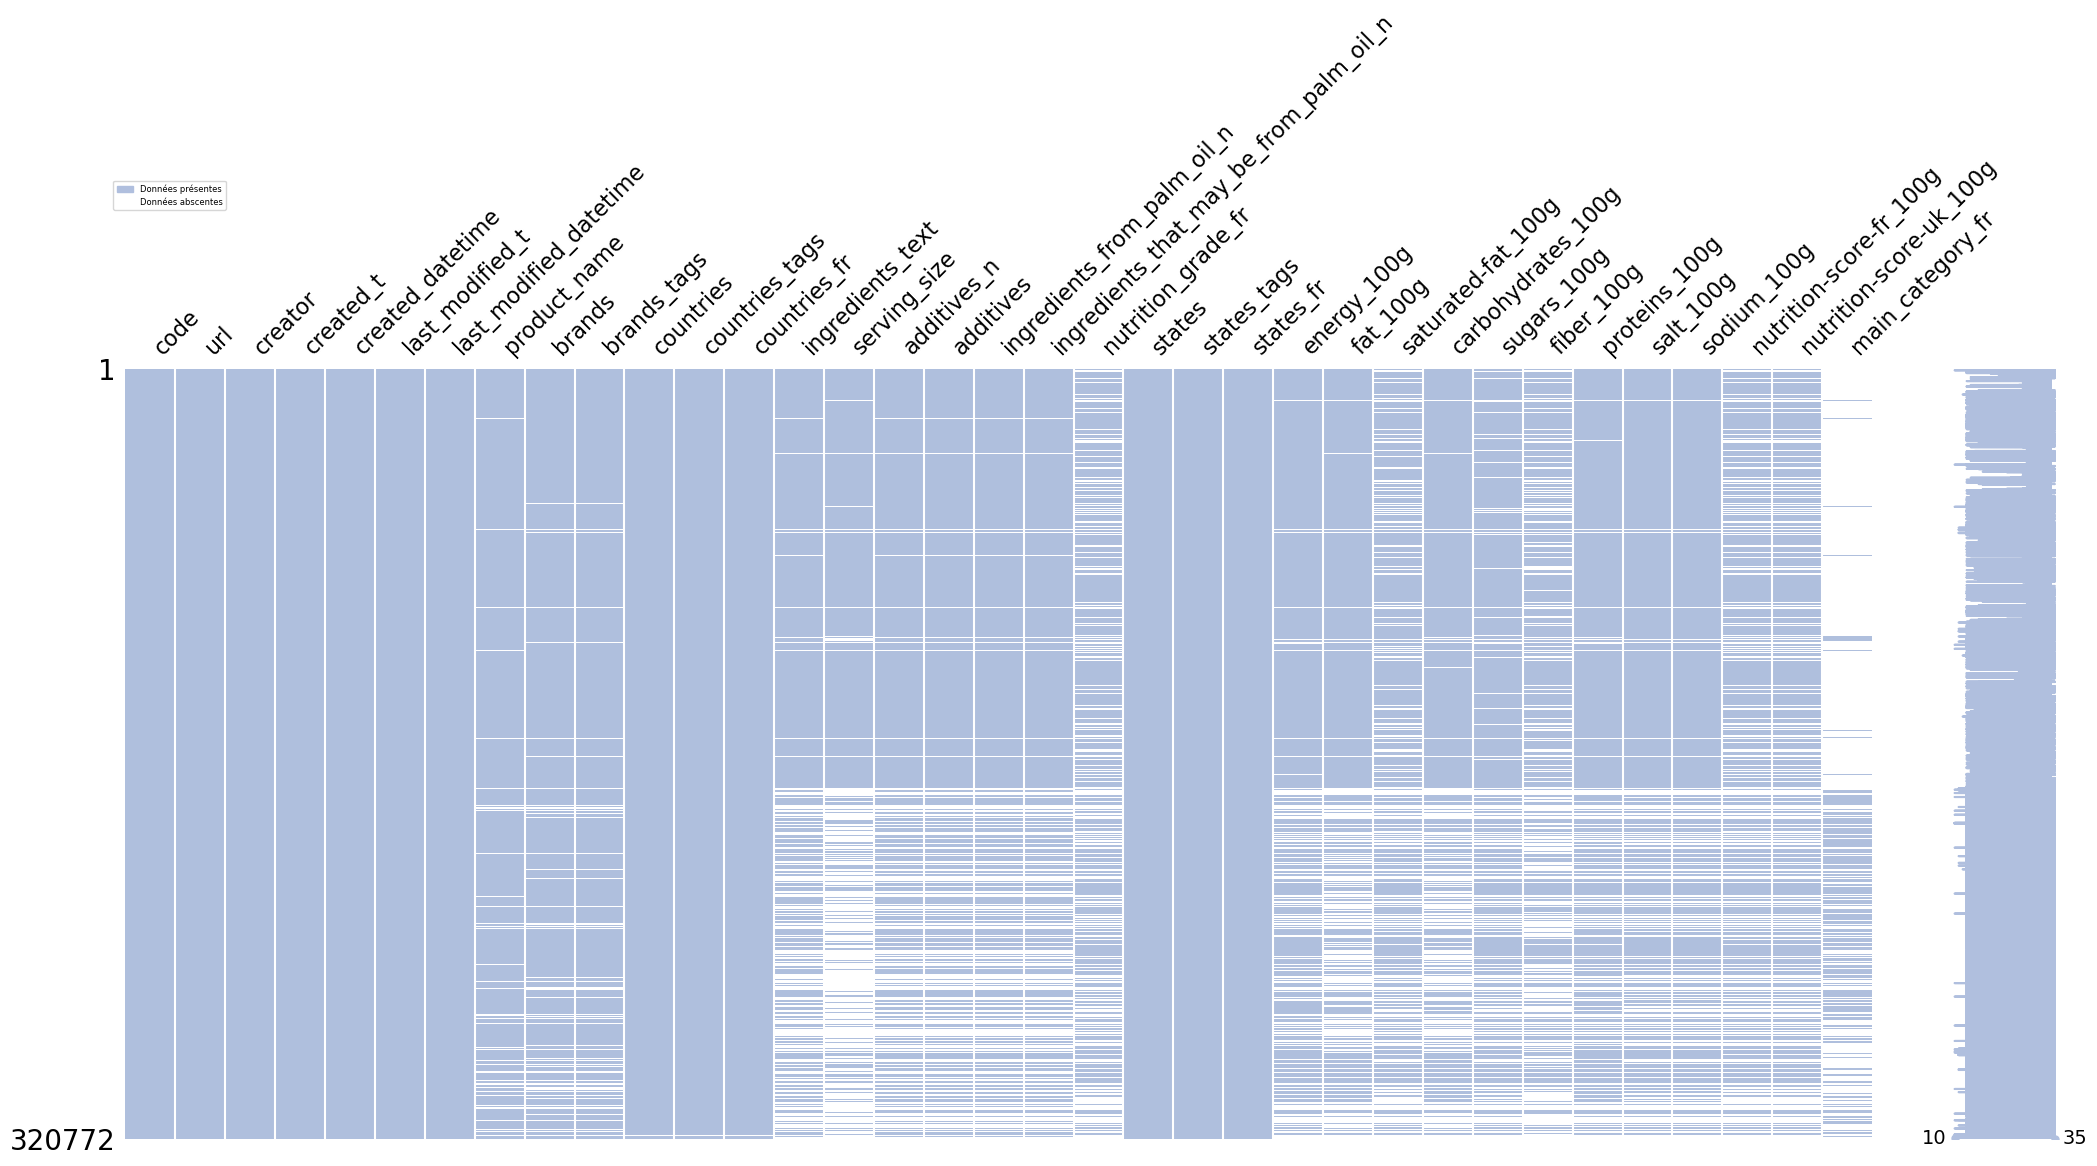

In [15]:
# Création d'un diagramme de matrice de données manquantes pour l'ensemble de données 
fig = msno.matrix(sampling_open_food, color=(0.69,0.75,0.87))

# Création d'un objet Patch pour les données présentes 
blue_patch = mpatches.Patch(color=(0.69,0.75,0.87), label='Données présentes')
white_patch = mpatches.Patch(color='white', label='Données abscentes')

# Ajout d'une légende à la figure en utilisant les objets Patch créés
fig.legend(bbox_to_anchor=(0.06, 1.25), handles=[blue_patch, white_patch])

# Création d'une copie de la figure
fig_copy = fig.get_figure()

# Enregistrement de la figure dans un fichier image
fig_copy.savefig("./export/img/005_sampling_open_food_empty_data.png", dpi=300,bbox_inches='tight')

Les deux graphiques ci-dessus et ci-dessous aident à déterminer les colonnes qui ont le plus grand pourcentage de valeurs manquantes et à évaluer la qualité des données pour ces colonnes en particulier.
Cela peut également aider à déterminer les colonnes qui peuvent être éliminées ou les valeurs qui peuvent être imputées en conséquence.
En fin de compte, cela peut contribuer à améliorer la qualité et la fiabilité des analyses et des modèles basés sur les données.

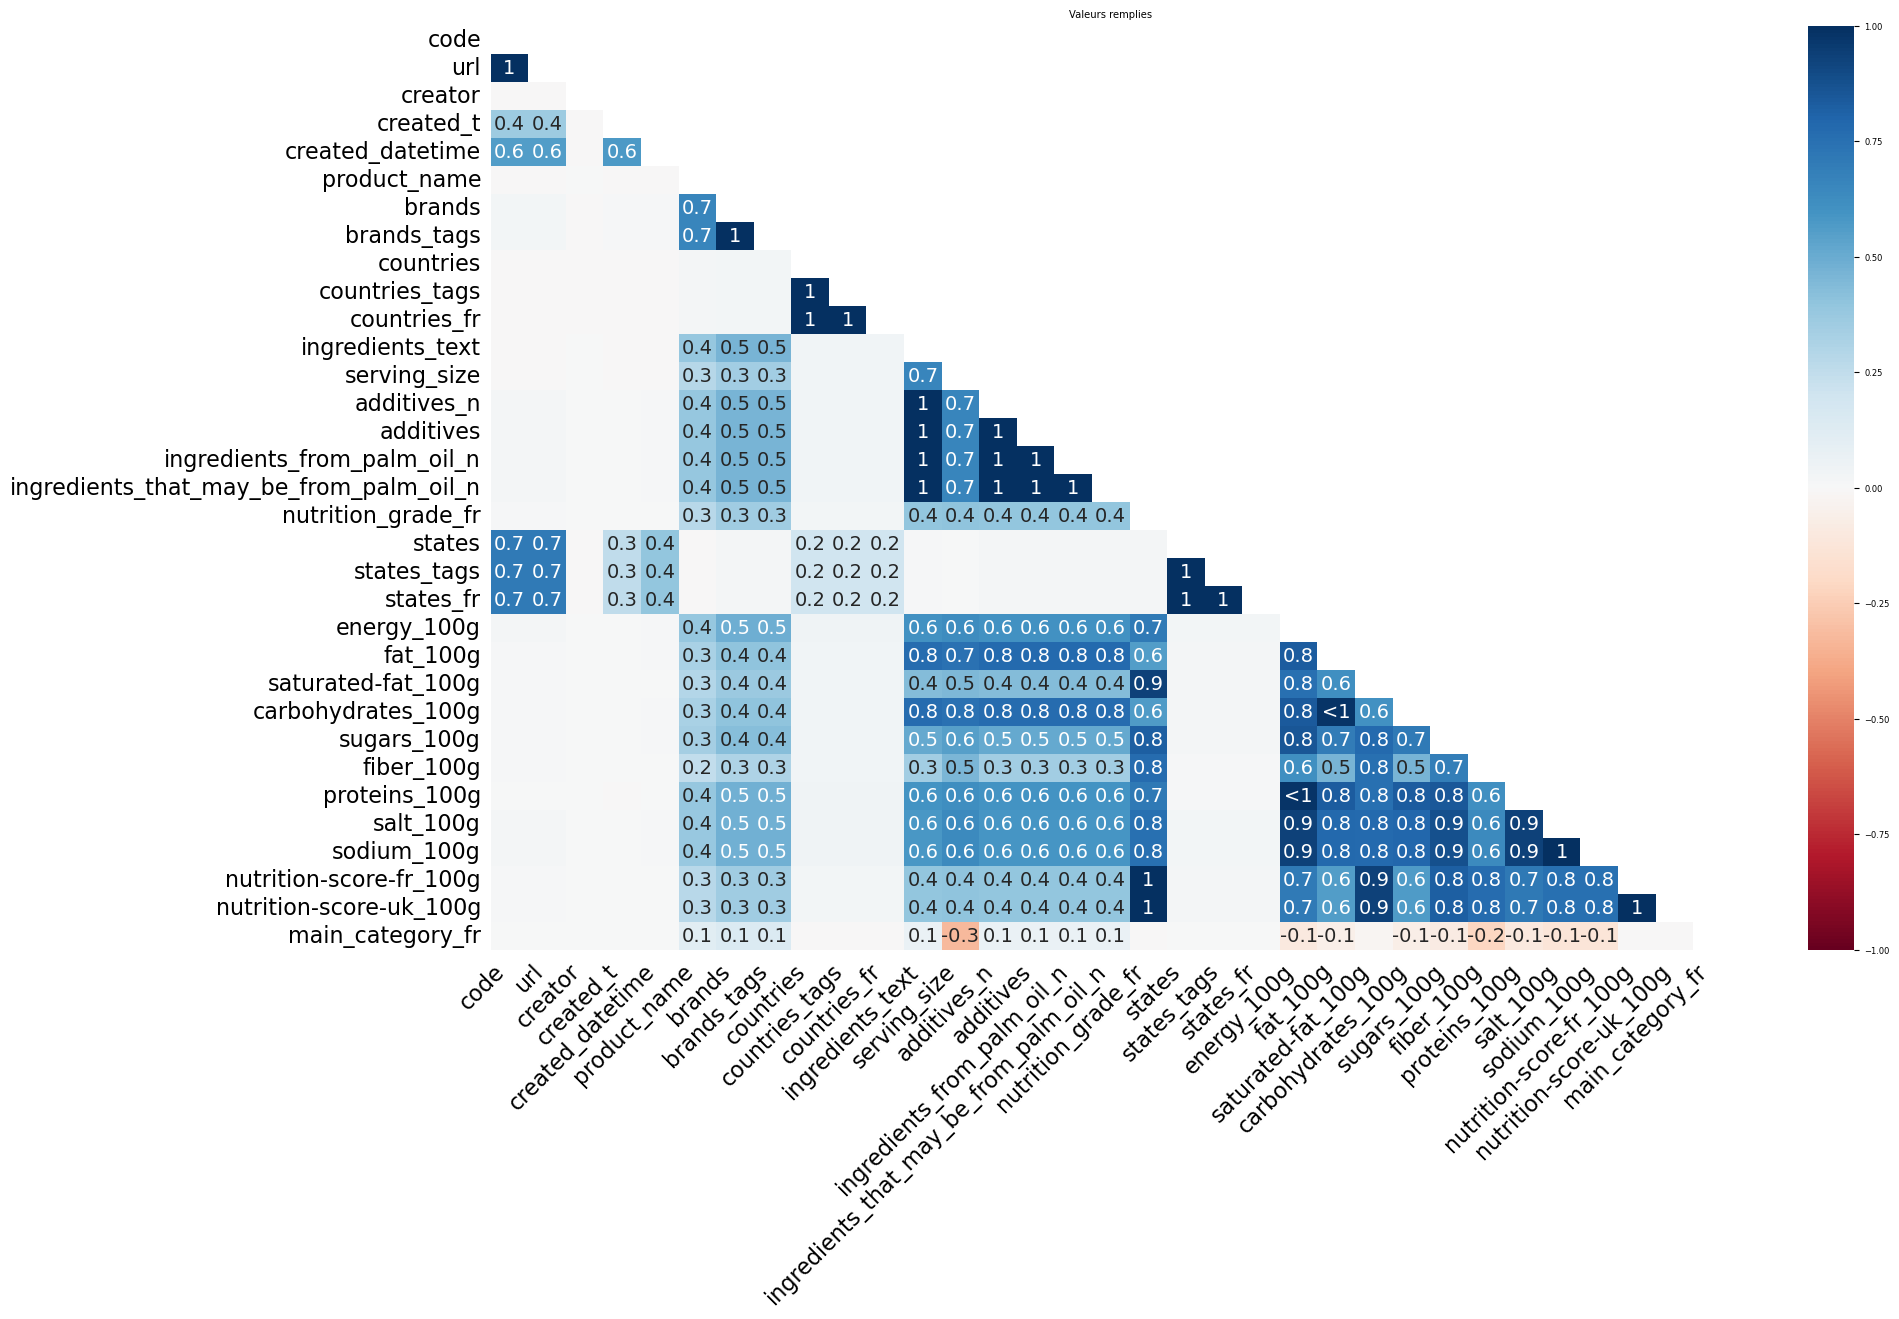

In [16]:
# Création d'un heatmap pour visualiser les données manquantes dans l'ensemble de données sampling_open_food
fig = msno.heatmap(sampling_open_food)

fig.set_title('Valeurs remplies')

# Création d'une copie de la figure
fig_copy = fig.get_figure()

# Enregistrement de la figure dans un fichier image
fig_copy.savefig("./export/img/006_sampling_open_food_heatmap.png", dpi=300, bbox_inches='tight')

Priorité : uniformiser les titres des colonnes

In [17]:
# Priorité : modification des titres de colonne qui contienent un tiret
# -> uniformiser le nommage des titres avec des underscore
sampling_open_food = sampling_open_food.rename(columns={"saturated-fat_100g":"saturated_fat_100g"})
sampling_open_food = sampling_open_food.rename(columns={"nutrition-score-fr_100g":"nutrition_score_fr_100g"})
sampling_open_food = sampling_open_food.rename(columns={"nutrition-score-uk_100g":"nutrition_score_uk_100g"})

In [18]:
# Compteur des doublons avec un code identique
sampling_open_food.duplicated('code').value_counts()

False    320750
True         22
dtype: int64

Suppréssion des doublons avec un code identique

In [19]:
# Suppréssion des doublons avec un code identique
sampling_open_food.drop_duplicates('code', inplace=True)

In [20]:
# Compteur des doublons avec une url identique
sampling_open_food.duplicated('url').value_counts()

False    320750
dtype: int64

In [21]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 320,750 entrées réparties dans 35 colonnes


In [22]:
# Suppression des colonnes inutiles pour l'analyse
index_list = ['code','url','creator','created_datetime','created_t','last_modified_datetime','last_modified_t','serving_size','countries','states','states_tags','states_fr'] #'countries_tags',
sampling_open_food.drop(index_list, axis = 1, inplace =True)

In [23]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 320,750 entrées réparties dans 23 colonnes


Passage à une première sélection de 23 colonnes contenant l'ensemble des produits

Et maintenant comparaison de valeurs bien renseignés mais qui font office de doublons

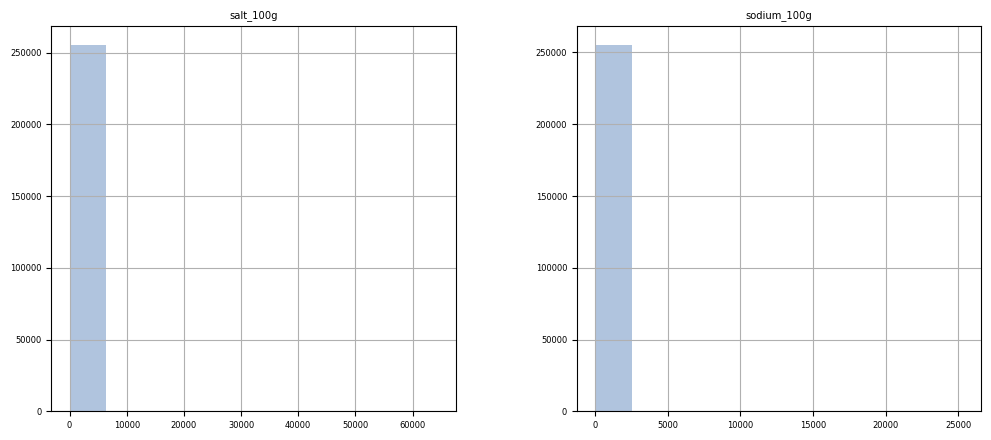

In [24]:
# Comparaison des valeurs de sel et sodium qui peuvent être identique
sampling_open_food.loc[:,['salt_100g','sodium_100g']].hist(figsize=(12, 5),color='lightsteelblue')
plt.savefig("./export/img/007_sampling_open_food_salt_vs_sodium.png", dpi=300, bbox_inches='tight')

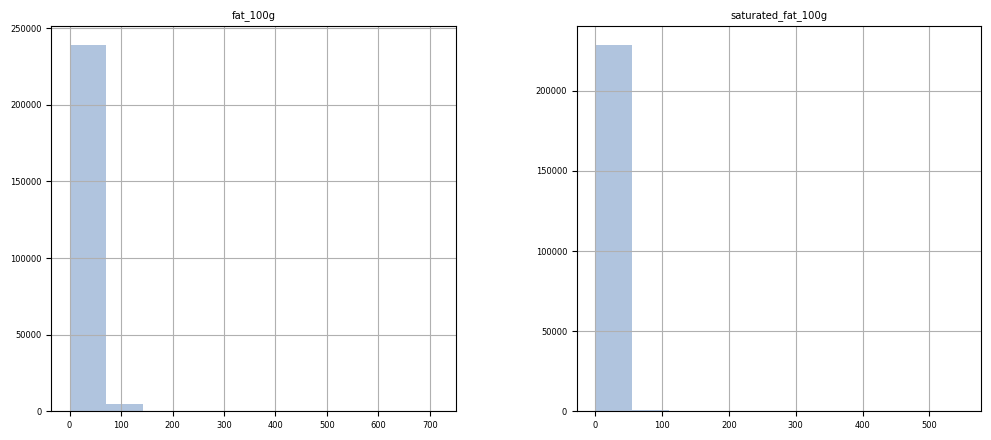

In [25]:
# Comparaison des valeurs de fat_100g et saturated_fat_100g qui peuvent être identique
sampling_open_food.loc[:,['fat_100g','saturated_fat_100g']].hist(figsize=(12, 5),color='lightsteelblue')
plt.savefig("./export/img/008_sampling_open_food_job_histogram_fat_vs_satured_fat.png", dpi=300, bbox_inches='tight')

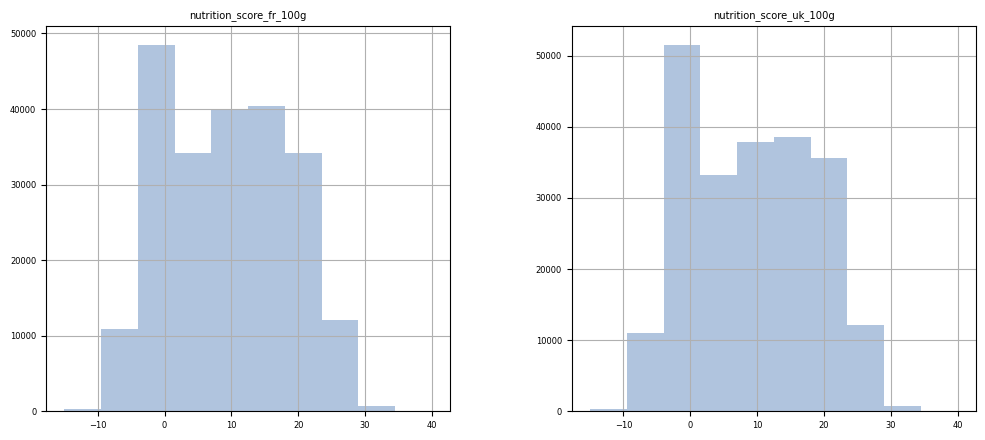

In [26]:
# Comparaison des valeurs de nutrition_score_fr_100g et nutrition_score_uk_100g qui peuvent être identique
sampling_open_food.loc[:,['nutrition_score_fr_100g','nutrition_score_uk_100g']].hist(figsize=(12, 5),color='lightsteelblue')
plt.savefig("./export/img/009_sampling_open_food_job_histogram_sccorefr_vs_scoreuk.png", dpi=300, bbox_inches='tight')

Deuxième vague de sélection des colonnes

In [27]:
columns_object_selected = ['product_name', 'brands', 'countries_tags', 'ingredients_text', 'nutrition_grade_fr', 'main_category_fr']
# Colonnes supprimés pour la suite :  'brands_tags' et 'additives'
print(sampling_open_food[columns_object_selected].columns.to_list())

# En conséquence de ces trois comparaisons je procéde à une nouvelle séléection des données 
# Energie / Lipides / Glucides / Proteines / Sel et Nutriscore
columns_float_selected = ['energy_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']
# Colonnes supprimés pour la suite : additives_n, ingredients_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_n, energy_100g, saturated_fat_100g, fiber_100g, sodium_100g, nutrition_score_uk_100g
print(sampling_open_food[columns_float_selected].columns.to_list())

# columns_boolean_selected = ['composed_product']

columns_selected_full = ['product_name', 'brands', 'countries_tags', 'ingredients_text', 'nutrition_grade_fr', 'main_category_fr', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']

sampling_open_food = sampling_open_food[columns_selected_full]
# pd.concat([sampling_open_food_job[columns_object_selected],sampling_open_food_job[columns_float_selected]], axis=1)

['product_name', 'brands', 'countries_tags', 'ingredients_text', 'nutrition_grade_fr', 'main_category_fr']
['energy_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']


In [28]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 320,750 entrées réparties dans 13 colonnes


Le jeu de données final comportera donc 13 colonnes

Création d'un heatmap pour visualiser les données manquantes dans l'ensemble de données sampling_open_food après suppression des colonnes avec des données manquantes

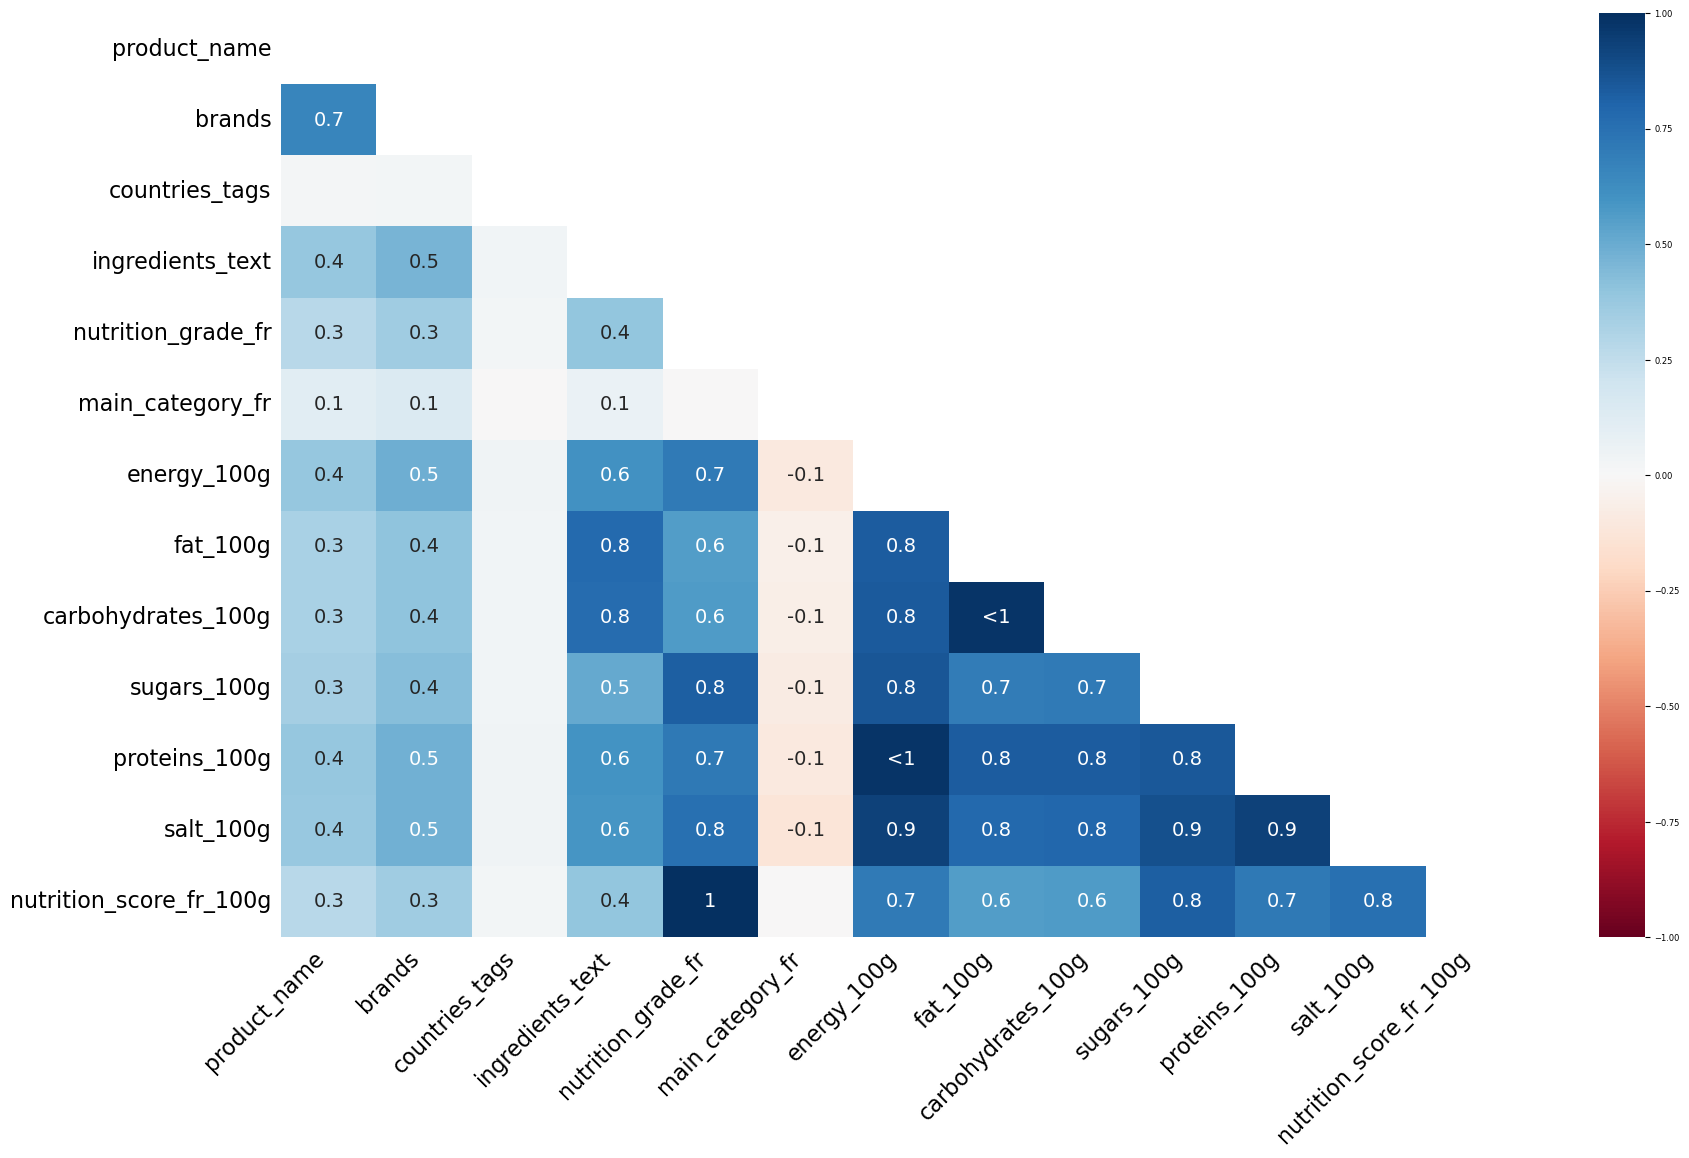

In [29]:
# Création d'un heatmap pour visualiser les données manquantes dans l'ensemble de données sampling_open_food après suppression des colonnes avec des données manquantes
fig = msno.heatmap(sampling_open_food)

# Création d'une copie de la figure
fig_copy = fig.get_figure()

# Enregistrement de la figure dans un fichier image
fig_copy.savefig("./export/img/010_sampling_open_food_heatmap_after_drop.png", dpi=300, bbox_inches='tight')

<h3>Pré-visualisation du nouveau jeu de données</h3>

Aperçu du types de données qui vont être traités

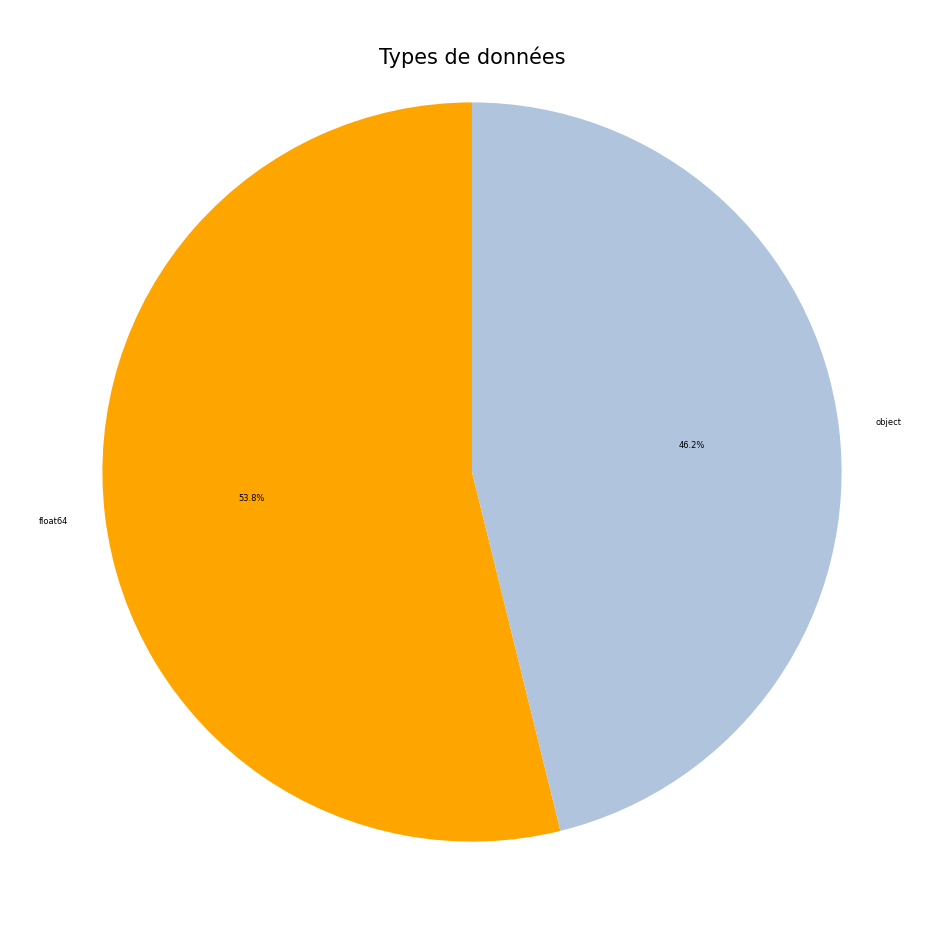

In [30]:
# Création d'un diagramme en camembert pour visualiser les types de données dans l'ensemble de données sampling_open_food
fig = sampling_open_food.dtypes.value_counts().plot(kind='pie', label='', autopct='%1.1f%%', startangle=90, colors = ['orange', 'lightsteelblue']) # , colors = ['orangered', 'lightsteelblue']

# Ajout d'un titre au diagramme 
fig.text(.0, 1.15, 'Types de données', ha='center', va='top' , size=15)

# Création d'une copie de la figure
fig_copy = fig.get_figure()

# Enregistrement de la figure dans un fichier image
fig_copy.savefig("./export/img/011_sampling_open_food_type_of_data.png", dpi=300, bbox_inches='tight')


In [31]:
# Création d'une copie de l'ensemble de données sampling_open_food
sampling_open_food_copy = sampling_open_food.copy()

<h4>Valeurs catégorielles</h4>

Liste des noms de colonnes de l'ensemble de données de type "object"

In [32]:
# Création d'une liste des noms de colonnes de l'ensemble de données de type object
sampling_open_food[columns_object_selected].columns.to_list()

['product_name',
 'brands',
 'countries_tags',
 'ingredients_text',
 'nutrition_grade_fr',
 'main_category_fr']

In [33]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(sampling_open_food[columns_object_selected].columns.to_list()),'./export/img/012_sampling_open_food_object.png', table_conversion="matplotlib", max_cols=-1)

Analyse et suppression des doublons

In [34]:
# Compter les valeurs dupliquées dans l'ensemble de données sampling_open_food_object en se basant sur certaines colonnes
sampling_open_food.duplicated(subset=columns_object_selected).value_counts()

False    301080
True      19670
dtype: int64

In [35]:
# Supprimer les valeurs dupliquées dans l'ensemble de données sampling_open_food_object en se basant sur certaines colonnes
sampling_open_food.drop_duplicates(subset=columns_object_selected, keep='first', inplace=True)

In [36]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 301,080 entrées réparties dans 13 colonnes


Affichage du nombre de produits par pays et sélection des pays les plus important en nombre

In [37]:
# Affichage du nombre de produits par pays

# Enlever "en:" de chaque valeur de la colonne
sampling_open_food['countries_tags'] = sampling_open_food['countries_tags'].str.replace('en:', '')

# Compter les valeurs de la colonne "countries_tags" de l'ensemble de données sampling_open_food et afficher les 10 premier pays
sampling_open_food.loc[:,'countries_tags'].value_counts().head(10)

united-states         168420
france                 87124
switzerland            12841
germany                 7015
spain                   4517
united-kingdom          3678
belgium                 1973
australia               1625
russia                  1270
france,switzerland      1218
Name: countries_tags, dtype: int64

In [38]:
# Récupérer les valeurs uniques de la colonne countries_fr qui apparaissent dans les 9 premières valeurs
countries_list = sampling_open_food.loc[:,'countries_tags'].value_counts().head(9).index.tolist()

# Filtrer les lignes où la valeur de la colonne countries_fr ne fait pas partie de la liste countries_list
sampling_open_food = sampling_open_food[sampling_open_food['countries_tags'].isin(countries_list)]

In [39]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(sampling_open_food.loc[:,'countries_tags'].value_counts().head(9)),'./export/img/013_sampling_open_food_object_countries_tags.png', table_conversion="matplotlib", max_cols=-1)

In [40]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 288,463 entrées réparties dans 13 colonnes


Affichage des 50 catégories les plus représentés (en nombre de produits par catégorie)

In [41]:
# Enlever "en:" de chaque valeur de la colonne
sampling_open_food['main_category_fr'] = sampling_open_food['main_category_fr'].str.replace('en:', '')
# Traduire éventuellement mais nécessite une connection internet


In [42]:
# Affichage des différentes catégories
sampling_open_food.loc[:,'main_category_fr'].value_counts().head(50)

Boissons                                   5320
Epicerie                                   2622
Aliments et boissons à base de végétaux    2510
Chocolats                                  2437
Conserves                                  2425
Plats préparés                             1990
Biscuits                                   1858
Surgelés                                   1821
Snacks sucrés                              1713
Fromages                                   1660
Pains                                      1609
Desserts                                   1579
Petit-déjeuners                            1555
Pâtes alimentaires                         1382
Plats à base de viande                     1276
Gâteaux                                    1186
Chips et frites                            1118
Produits à tartiner salés                  1087
Légumes frais                              1059
Bonbons                                     981
Laits                                   

In [43]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(sampling_open_food.loc[:,'main_category_fr'].value_counts().head(50)),'./export/img/014_sampling_open_food_object_categories_by_countries.png', table_conversion="matplotlib", max_cols=-1)

<h4>Valeurs numériques</h4>

Liste des noms de colonnes de l'ensemble de données de type "float"

In [44]:
# Création d'une liste des noms de colonnes de l'ensemble de données de type float
sampling_open_food[columns_float_selected].columns.to_list()

['energy_100g',
 'sugars_100g',
 'fat_100g',
 'carbohydrates_100g',
 'proteins_100g',
 'salt_100g',
 'nutrition_score_fr_100g']

In [45]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(sampling_open_food[columns_float_selected].columns.to_list()),'./export/img/015_sampling_open_food_float.png', table_conversion="matplotlib", max_cols=-1)

Aperçu des données numériques

In [46]:
# Aperçu des données numériques
sampling_open_food[columns_float_selected].describe(include='all')

,energy_100g,sugars_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,2.487860e+05,233951.000000,231721.000000,231447.000000,247600.000000,243878.000000,211394.000000
mean,1.140282e+03,15.981570,12.654232,32.131737,7.094658,2.058806,9.156750
std,6.598194e+03,22.368268,17.423053,29.752354,8.434122,131.284281,9.040361
min,0.000000e+00,-17.860000,0.000000,0.000000,-800.000000,0.000000,-15.000000
25%,3.810000e+02,1.300000,0.000000,6.010000,0.700000,0.063500,1.000000
50%,1.100000e+03,5.700000,5.000000,20.980000,4.760000,0.591820,10.000000
75%,1.674000e+03,24.000000,20.000000,58.330000,10.000000,1.391920,16.000000
max,3.251373e+06,3520.000000,714.290000,2916.670000,430.000000,64312.800000,40.000000


In [47]:
# Enregistrement de la figure dans un fichier image
dfi.export(sampling_open_food[columns_float_selected].describe(include='all'),"./export/img/016_sampling_open_food_float_head.png", table_conversion="matplotlib", max_cols=-1)

In [48]:
# Vérification de la moyenne des valeurs de type "float"
sampling_columns_float_mean = sampling_open_food[columns_float_selected].isna().mean()
sampling_columns_float_mean = pd.DataFrame(sampling_columns_float_mean, columns=['mean'])
sampling_columns_float_mean.head(13)

,mean
energy_100g,0.137546
sugars_100g,0.188974
fat_100g,0.196705
carbohydrates_100g,0.197654
proteins_100g,0.141658
salt_100g,0.154561
nutrition_score_fr_100g,0.267171


In [49]:
# Sauvegarde en image de "columns_float"
dfi.export(sampling_columns_float_mean.head(12),"./export/img/017_dataframe_columns_float_mean.png", table_conversion="matplotlib", max_cols=-1)

In [50]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 288,463 entrées réparties dans 13 colonnes


In [51]:
# Affichage des informations générales sur l'ensemble de données
sampling_open_food[columns_float_selected].info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288463 entries, 0 to 320771
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   energy_100g              248786 non-null  float64
 1   sugars_100g              233951 non-null  float64
 2   fat_100g                 231721 non-null  float64
 3   carbohydrates_100g       231447 non-null  float64
 4   proteins_100g            247600 non-null  float64
 5   salt_100g                243878 non-null  float64
 6   nutrition_score_fr_100g  211394 non-null  float64
dtypes: float64(7)
memory usage: 17.6 MB


In [52]:
# Version enregistrable en image
info_df = pd.DataFrame(columns_float_selected, columns=['column_name'])
info_df['non_null_count'] = sampling_open_food[columns_float_selected].count()
info_df['total_count'] = len(sampling_open_food)
info_df['null_count'] = info_df['total_count'] - info_df['non_null_count']
info_df['null_ratio'] = info_df['null_count'] / info_df['total_count']

# Sauvegarde en image de "columns_float"
dfi.export(info_df.head(13),"./export/img/018_dataframe_columns_float_information.png", table_conversion="matplotlib", max_cols=-1)

In [53]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food.shape[1]))

Le jeu de données compte 288,463 entrées réparties dans 13 colonnes


In [54]:
# Sauvegarde de l'échantillonnage dans un nouveau dataframe
sampling_open_food_job = sampling_open_food.copy()
# sampling_open_food_stat = sampling_open_food.copy()

<h3>Nettoyage des données basé sur la connaissance métier</h3>

<h4>Valeurs abscentes</h4>

In [55]:
# Sélectionner les colonnes de type float64 pour identifier les produits composés
# ['energy_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']

# Créer une nouvelle colonne pour stocker les informations sur les produits composés
sampling_open_food_job['composed_product'] = False

# Parcourir chaque ligne du dataframe
for i, row in sampling_open_food_job.iterrows():
    # Initialiser un compteur pour compter le nombre de valeurs non nulles dans les colonnes sélectionnées
    non_null_count = 0
    # Parcourir chaque colonne sélectionnée
    for column in columns_float_selected:
        # Si la valeur n'est pas nulle, ajouter 1 au compteur
        if not pd.isnull(row[column]):
            non_null_count += 1
    # Si le compteur est égal au nombre de colonnes sélectionnées, cela signifie que la ligne est un produit composé
    if non_null_count == len(columns_float_selected):
        sampling_open_food_job.at[i, 'composed_product'] = True

# Afficher les lignes qui sont des produits composés
composed_products = sampling_open_food_job[sampling_open_food_job['composed_product'] == True]

# composed_products.head(10)

In [56]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(composed_products.head(10)),'./export/img/019_sampling_open_food_job_composed_products.png', table_conversion="matplotlib", max_cols=-1)

In [57]:
# Afficher les lignes qui ne sont pas des produits composés
single_value_products = sampling_open_food_job[sampling_open_food_job['composed_product'] == False]
# single_value_products.head(10)

In [58]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(single_value_products.head(10)),'./export/img/020_sampling_open_food_job_composed_products.png', table_conversion="matplotlib", max_cols=-1)

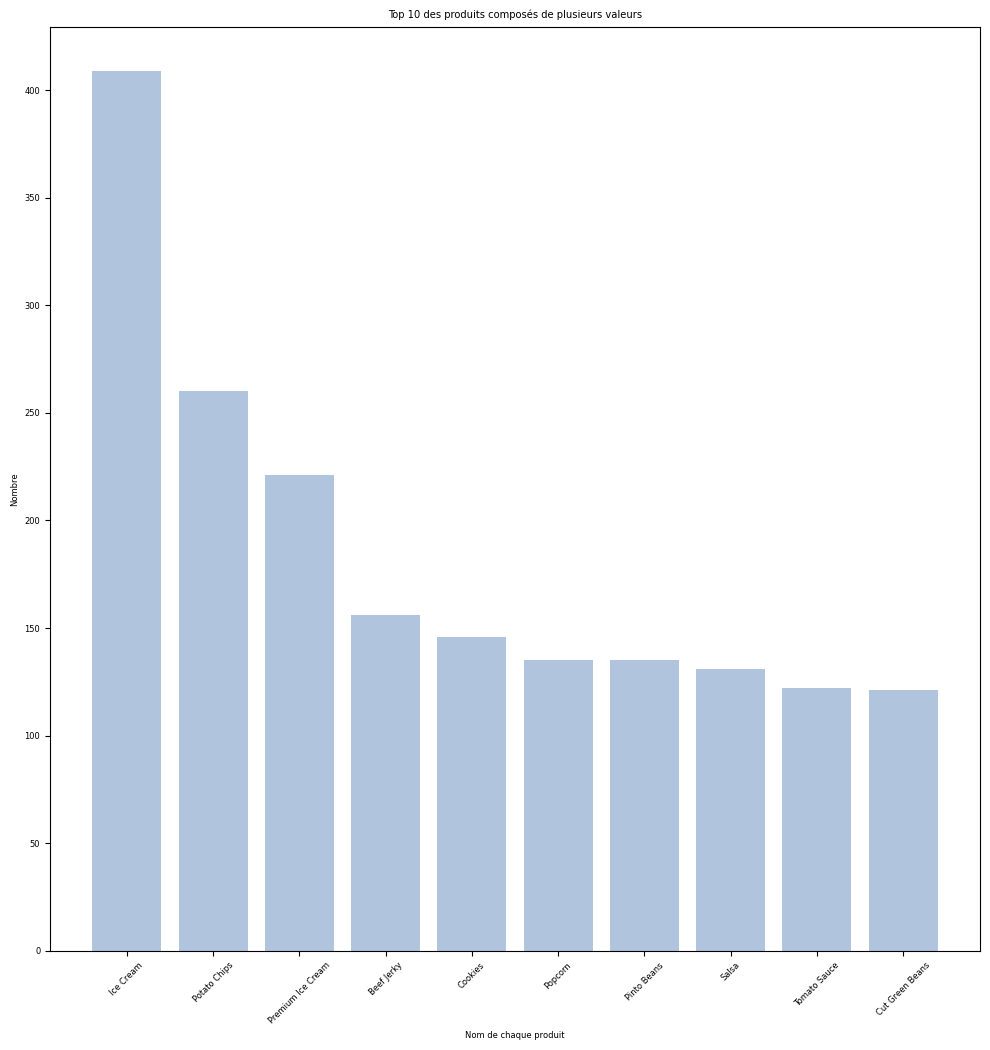

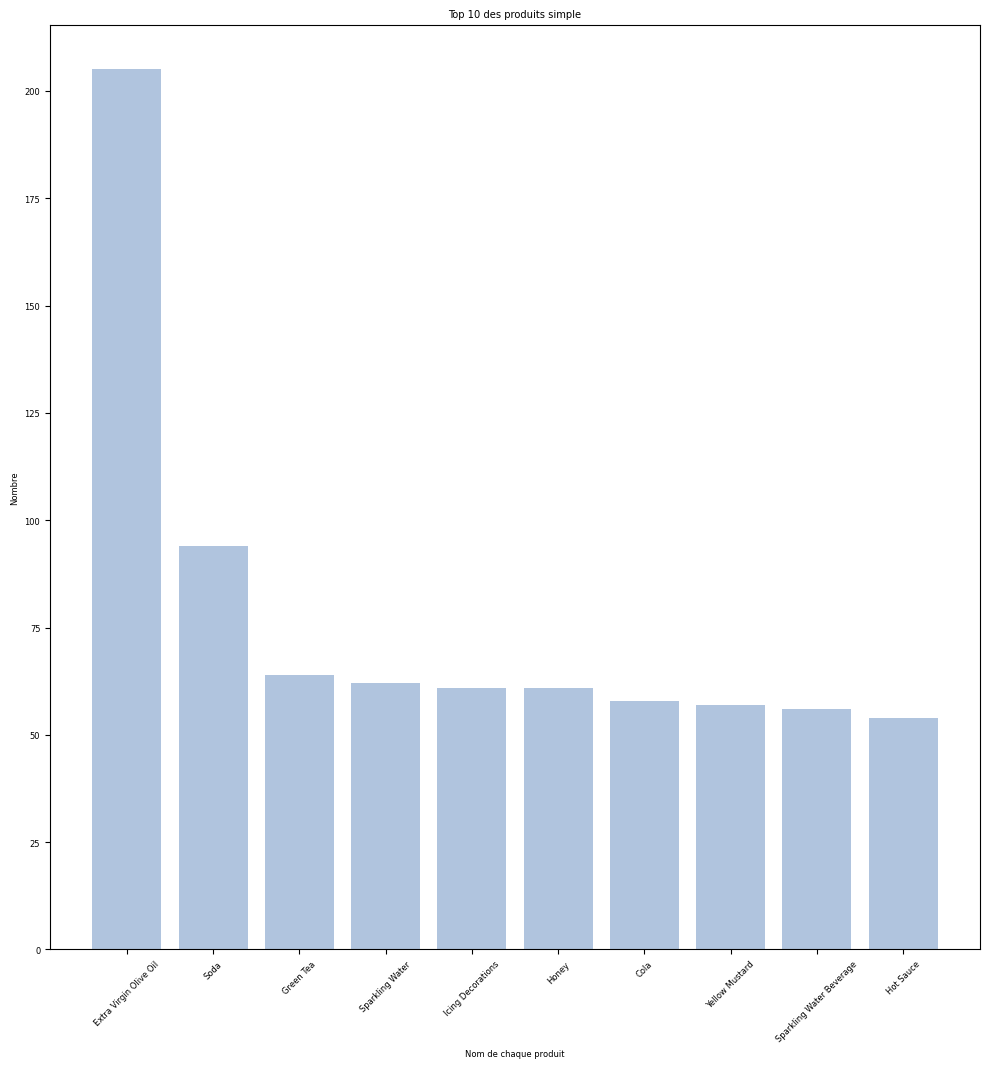

In [59]:
# Extraire les 10 premiers produits composés
top_composed_products = composed_products.head(10)

# Extraire les 10 premiers produits à une seule valeur
top_single_value_products = single_value_products.head(10)

# Compter le nombre de produits composés et simples
composed_counts = composed_products['product_name'].value_counts().head(10)
single_value_counts = single_value_products['product_name'].value_counts().head(10)

# Définir les données pour les bar charts
composed_products_data = composed_counts.index
single_value_products_data = single_value_counts.index

# Afficher le premier bar chart pour les produits composés
plt.bar(composed_products_data, height=composed_counts.values, color='lightsteelblue')
plt.title('Top 10 des produits composés de plusieurs valeurs')
plt.xlabel('Nom de chaque produit')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
# Sauvegarde des graphiques en format "png"
plt.savefig("./export/img/021_open_food_noms_produits_composés.png", dpi=300, bbox_inches='tight')
plt.show()

# Afficher le deuxième bar chart pour les produits à une seule valeur
plt.bar(single_value_products_data, height=single_value_counts.values, color='lightsteelblue')
plt.title('Top 10 des produits simple')
plt.xlabel('Nom de chaque produit')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
# Sauvegarde des graphiques en format "png"
plt.savefig("./export/img/022_open_food_noms_produits_simple.png", dpi=300, bbox_inches='tight')
plt.show()

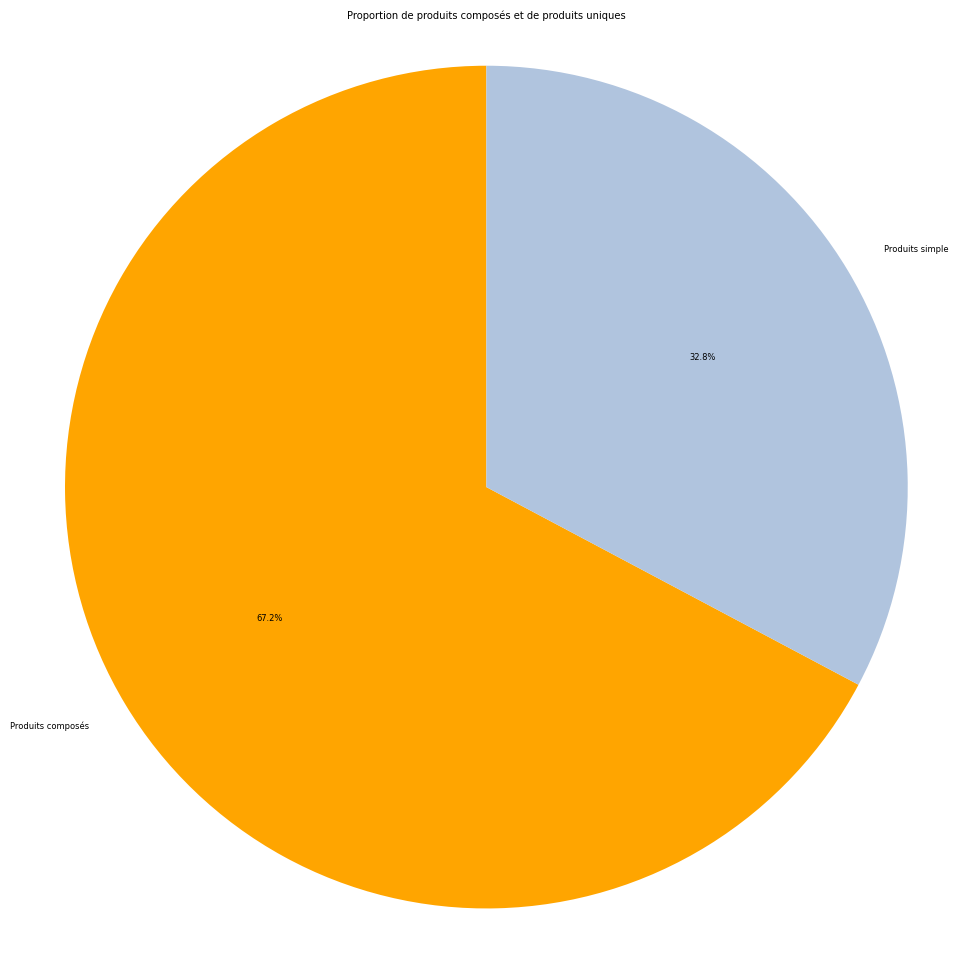

In [60]:
# Compter le nombre de produits composés
composed_count = len(composed_products)

# Compter le nombre de produits à une seule valeur
single_value_count = len(single_value_products)

# Définir les données pour le diagramme en camembert
labels = ['Produits composés', 'Produits simple']
sizes = [composed_count, single_value_count]

# Afficher le diagramme en camembert
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors = ['orange', 'lightsteelblue'])
plt.title("Proportion de produits composés et de produits uniques")
plt.axis('equal')

# Exportation de l'image de comparaison
plt.savefig("./export/img/024_open_food_composed_products.png", dpi=300, bbox_inches='tight')

plt.show()

Traitement de purge des lignes avec des valeurs "Not a Number" parmi les données de type Float

In [61]:
# Traitement de purge des lignes avec des valeurs "Not a Number" parmi les données de type Float
sampling_open_food_job = sampling_open_food_job.dropna(subset=columns_float_selected)

In [62]:
# Traitement de purge des lignes avec des valeurs "Not a Number" parmi les données de type object
# sampling_open_food_job = sampling_open_food_job.dropna(subset=columns_object_selected)

In [63]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food_job.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food_job.shape[1]))

Le jeu de données compte 193,932 entrées réparties dans 14 colonnes


In [64]:
# Outliers
# Traitement métier : outliers des valeurs inférieur à min_value et supérieur à max_value
def handlingOutliersMinMax(dataframe, columns, min_value, max_value):
    for column in columns :
        if dataframe[column].dtypes != 'float64':
            print(f"La colonne {column} n'est pas de type float64, la fonction ne peut pas s'appliquer")
            continue
            
        mask = (dataframe[column] >= max_value) | (dataframe[column] <= min_value) |  (dataframe[column].isna()) | (dataframe[column].isnull())

        index_to_drop =  dataframe.index[mask]

        dataframe.loc[index_to_drop, column] = np.nan
        
    return dataframe.copy()

# energy_100g valeurs comprises entre 0 et 3000
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["energy_100g"], 0., 3000)

# sugars_100g valeurs comprises entre 0 et 3600 # Sucres
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["sugars_100g"], 0., 3600)

# fat_100g valeurs comprises entre 0 et 1000 # Lipides
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["fat_100g"], 0., 1000)

# carbohydrates_100g valeurs comprises entre 0 et 3000 # Glucides
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["carbohydrates_100g"], 0., 3000.0)

# proteins_100g valeurs comprises entre 0 et 430 # Proteines
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["proteins_100g"], 0., 430.0)

# salt_100g valeurs comprises entre 0 et 64000 # Sel
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["salt_100g"], 0., 64000.0)

# nutrition_score_fr_100g valeurs comprises entre 0 et 100 # Nutriscore
sampling_open_food_job = handlingOutliersMinMax(sampling_open_food_job, ["nutrition_score_fr_100g"], -15., 100.0)

sampling_open_food_job[columns_float_selected].describe()

,energy_100g,sugars_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,190721.000000,163805.000000,157280.000000,183654.000000,168565.000000,174200.000000,193931.000000
mean,1170.080042,17.753866,16.409578,35.110482,8.937234,1.516798,9.155029
std,726.674684,20.313165,16.305894,27.935127,7.938805,14.537938,9.046158
min,0.600000,0.000500,0.000100,0.001000,0.004000,0.000001,-14.000000
25%,469.000000,3.100000,3.400000,9.170000,3.330000,0.193040,1.000000
50%,1197.000000,8.000000,11.760000,27.270000,6.700000,0.800000,10.000000
75%,1699.000000,28.000000,25.000000,60.000000,12.170000,1.500000,16.000000
max,2999.000000,134.000000,380.000000,190.000000,100.000000,3048.000000,40.000000


In [65]:
# Enregistrement de la figure dans un fichier image
dfi.export(pd.DataFrame(sampling_open_food_job[columns_float_selected].describe(include='all')),'./export/img/025_sampling_open_food_job_float.png', table_conversion="matplotlib", max_cols=-1)

In [66]:
# Traitement de purge des lignes avec des valeurs "Not a Number" parmi les données de type Float
sampling_open_food_job = sampling_open_food_job.dropna(subset=columns_float_selected)

In [67]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food_job.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food_job.shape[1]))

Le jeu de données compte 120,513 entrées réparties dans 14 colonnes


<h5>Exemple de traitement métier avec la valeur "sugars_100g"</h5>

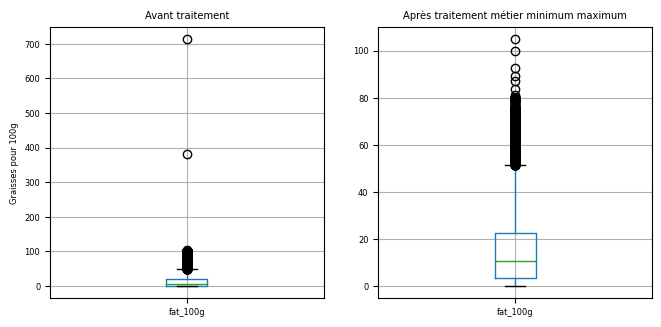

In [68]:
plt.figure(2)

plt.subplot(331)
sampling_open_food_copy.boxplot(column='fat_100g')
plt.title('Avant traitement')
plt.ylabel('Graisses pour 100g')

plt.subplot(332)
sampling_open_food_job.boxplot(column='fat_100g')
plt.title('Après traitement métier minimum maximum')

# Exportation de l'image des données avant et après traitement métier
plt.savefig("./export/img/026_open_food_sugars_100g.png", dpi=300, bbox_inches='tight')

plt.show()

In [69]:
# Sauvegarde de l'échantillonnage de données
sampling_open_food_job.to_csv('./export/csv/sampling_open_food_job.csv', sep=';') 

In [70]:
# Distinction entre le dataframe métier et le nouveau dataframe statistique
sampling_open_food_stat = sampling_open_food_job.copy()

<h3>Nettoyage des données basé sur la connaissance statistique</h3>

<h4>Traitement statistique interquartile</h4>

In [71]:
from scipy.stats import iqr

# Traitement statistique par mediane interquartile
def handlingOutliersStat(dataframe, column):
    
        interquartile = iqr(dataframe[column], nan_policy='omit')
        
        mediane = np.nanmedian(dataframe[column])
        
        lim_min = mediane - 1.5 * interquartile
        lim_max = mediane + 1.5 * interquartile
        
        return handlingOutliersMinMax(dataframe, column, lim_min, lim_max)

# energy_100g
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["energy_100g"])

# sugars_100g
# Sucres
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["sugars_100g"])

# fat_100g
# Gras (Lipides)
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["fat_100g"])

# carbohydrates_100g
# Glucides
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["carbohydrates_100g"])

# proteins_100g
# Proteines
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["proteins_100g"])

# salt_100g
# Sel
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["salt_100g"])

# nutrition_score_fr_100g
# Nutriscore
sampling_open_food_stat = handlingOutliersStat(sampling_open_food_stat, ["nutrition_score_fr_100g"])

sampling_open_food_stat[columns_float_selected].describe()

,energy_100g,sugars_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,120513.000000,106897.000000,113366.000000,120508.000000,107810.000000,111303.000000,120407.000000
mean,1264.950858,10.947290,12.440327,35.063460,6.369573,0.774538,10.138256
std,705.788309,11.498887,10.591132,25.817777,3.993764,0.610189,8.980538
min,1.000000,0.000500,0.001000,0.001000,0.004000,0.000001,-11.000000
25%,615.000000,2.300000,3.120000,10.400000,3.330000,0.198120,2.000000
50%,1272.000000,5.100000,9.680000,30.210000,5.770000,0.710000,11.000000
75%,1845.000000,18.450000,20.000000,58.200000,8.830000,1.180000,17.000000
max,2999.000000,41.600000,39.420000,100.000000,17.310000,2.440940,33.000000


In [72]:
# Affichage du nombre de lignes et de colonnes
print('Le jeu de données compte {:,} entrées '.format(sampling_open_food_stat.shape[0]) + 'réparties dans {} colonnes'.format(sampling_open_food_stat.shape[1]))

Le jeu de données compte 120,513 entrées réparties dans 14 colonnes


In [73]:
# Sauvegarde
dfi.export(sampling_open_food_stat[columns_float_selected].describe(),"./export/img/027_dataframe_float_interquartile.png", table_conversion="matplotlib", max_cols=-1)

<h4>Exemple de traitement métier et statistique avec la valeur "salt_100g"</h4>

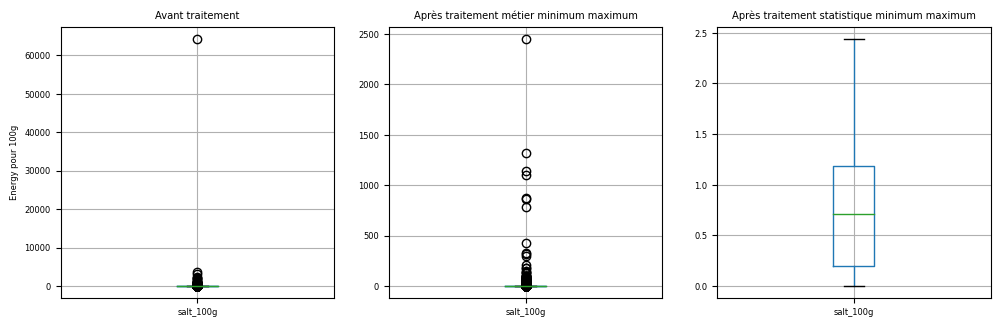

In [74]:
plt.figure(3)

plt.subplot(331)
sampling_open_food_copy.boxplot(column='salt_100g')
plt.title('Avant traitement')
plt.ylabel('Energy pour 100g')

plt.subplot(332)
sampling_open_food_job.boxplot(column='salt_100g')
plt.title('Après traitement métier minimum maximum')

plt.subplot(333)
sampling_open_food_stat.boxplot(column='salt_100g')
plt.title('Après traitement statistique minimum maximum')

# Exportation de l'image des données avant et après traitement métier
plt.savefig("./export/img/028_open_food_energie_salt_100g.png", dpi=300, bbox_inches='tight')

plt.show()

<h3>Comparatif de traitement métier et statistique avec les valeurs du jeu de données</h3>

In [75]:
# 
def plotsViolin(col, unit):
    plt.figure(3, figsize=(14, 10))
    plt.subplot(331)
    sns.violinplot(y=col, data=sampling_open_food_copy, color='lightsteelblue')
    plt.title('Avant traitement')
    plt.ylabel(unit)
    plt.xlabel(col)

    plt.subplot(332)
    sns.violinplot(y=col, data=sampling_open_food_job, color='lightsteelblue')
    plt.title('Après traitement métier')
    plt.ylabel(unit)
    plt.xlabel(col)

    plt.subplot(333)
    sns.violinplot(y=col, data=sampling_open_food_stat, color='lightsteelblue')
    plt.title('Après traitement statistique')
    plt.ylabel(unit)
    plt.xlabel(col)
    plt.tight_layout()
    
    # Sauvegarde des graphiques en format "png"
    plt.savefig("./export/img/029_open_food_{}_plots_violin_value.png".format(col), dpi=300, bbox_inches='tight')
    plt.show()

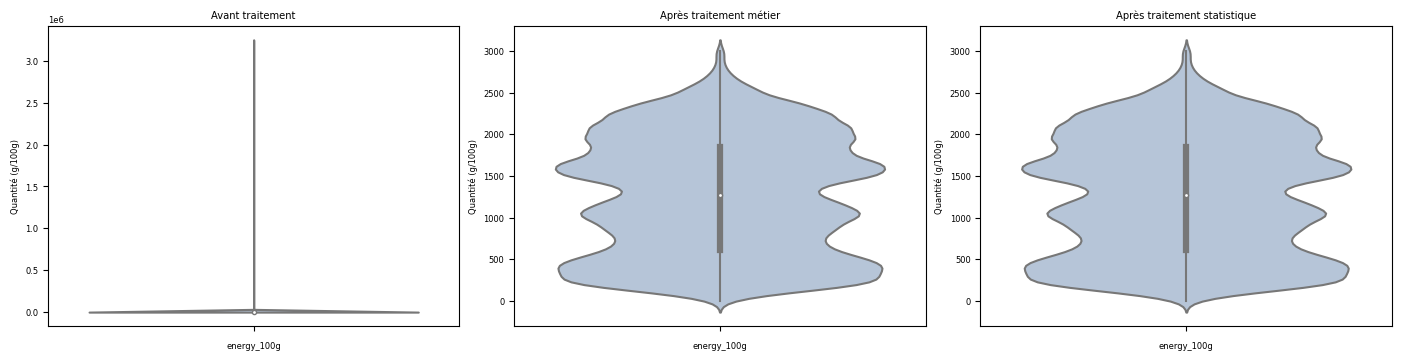

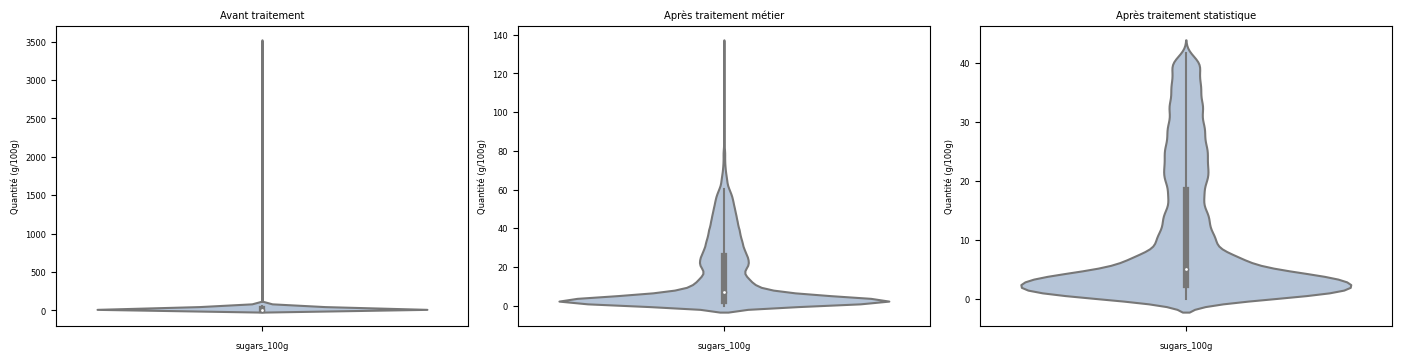

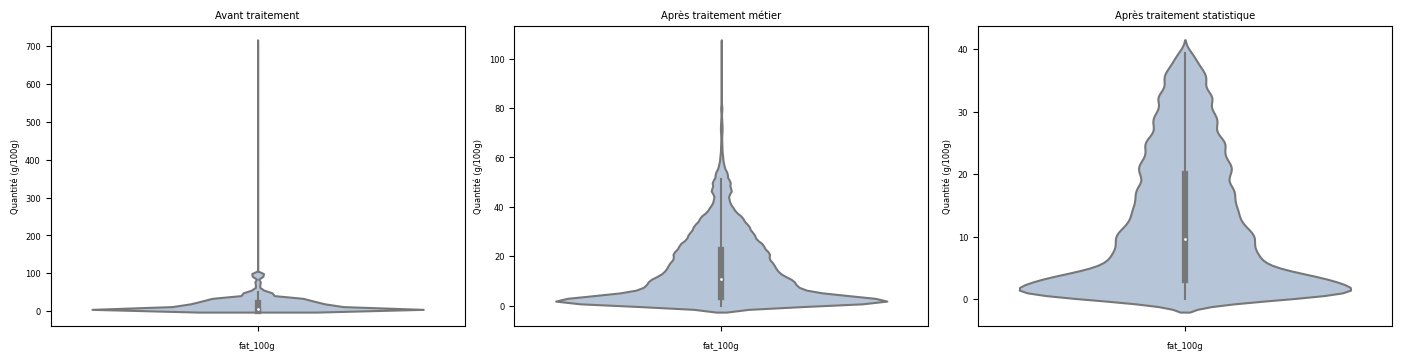

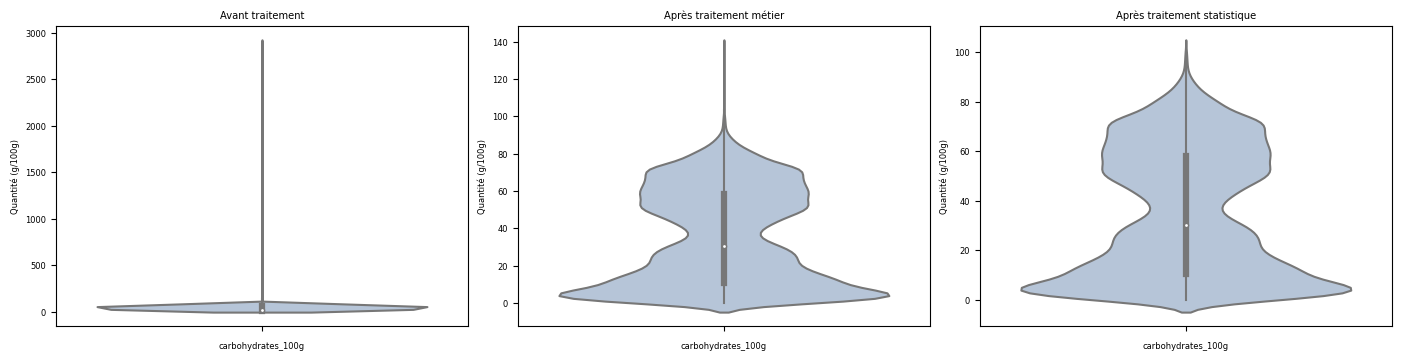

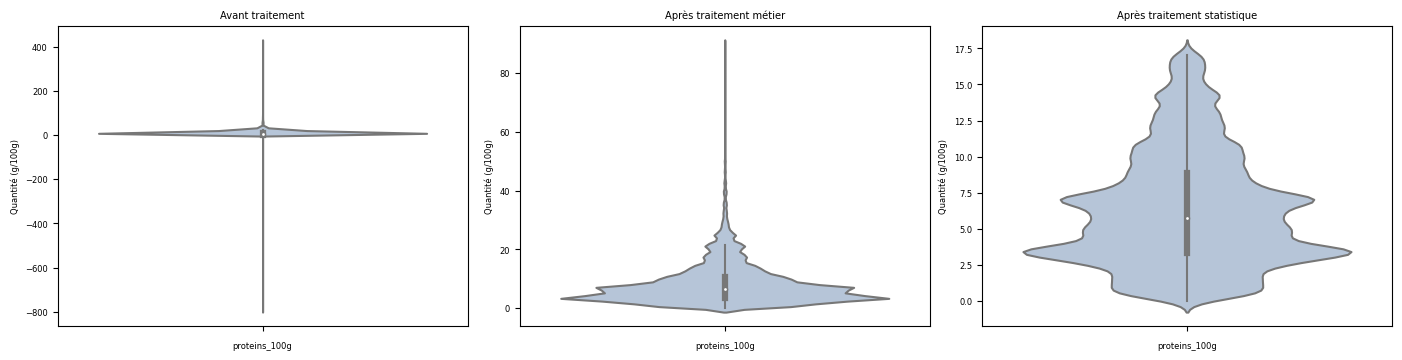

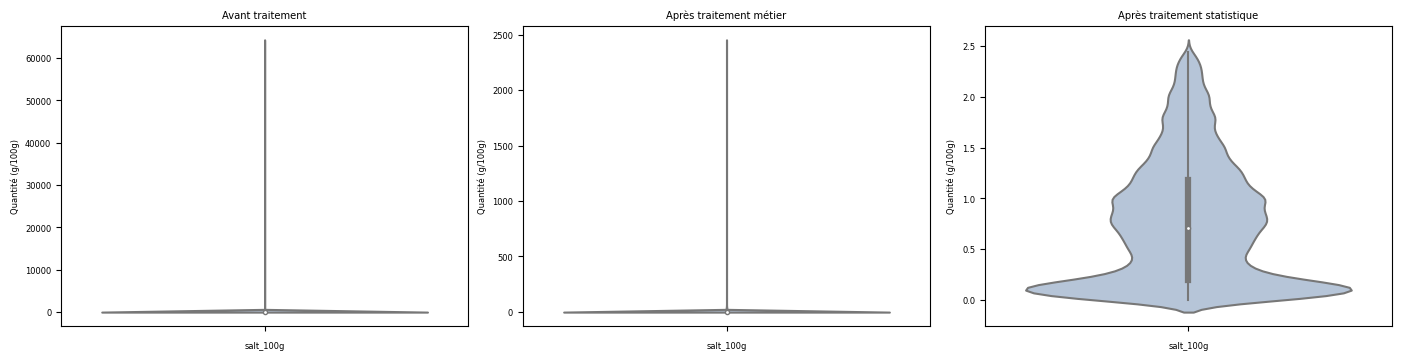

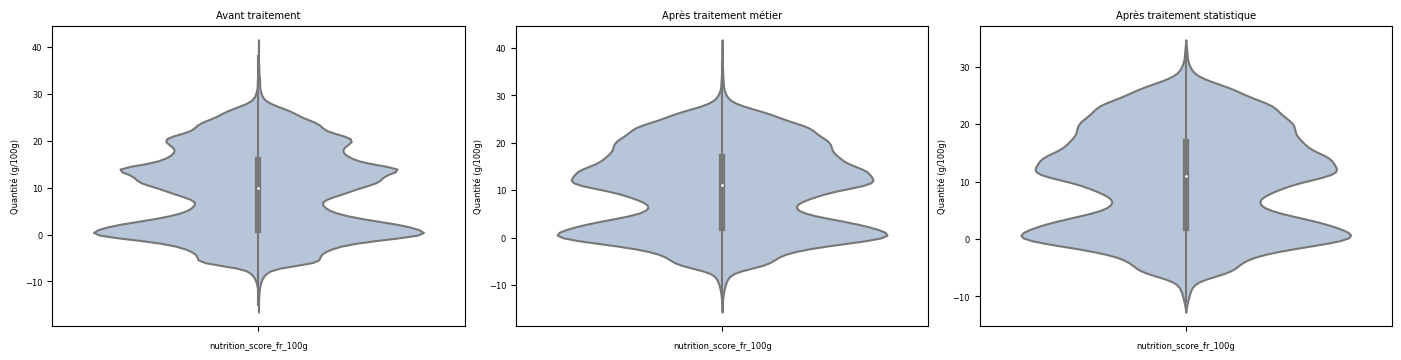

In [76]:
# 
for col in columns_float_selected:
    plotsViolin(col,'Quantité (g/100g)')

<h3>Analyse des résultats</h3>

<h4>Analyse uni-variée</h4>

<h5>Valeurs catégorielles</h5>

La variable "product_name" est difficile a représenter car il y a plus de 100 000 entrées dans le dataframe d'étude.
Néanmoins on peut s'intéresser aux produits les plus représentés. Le graphique ci-dessous montre les 15 produits les plus représentés.

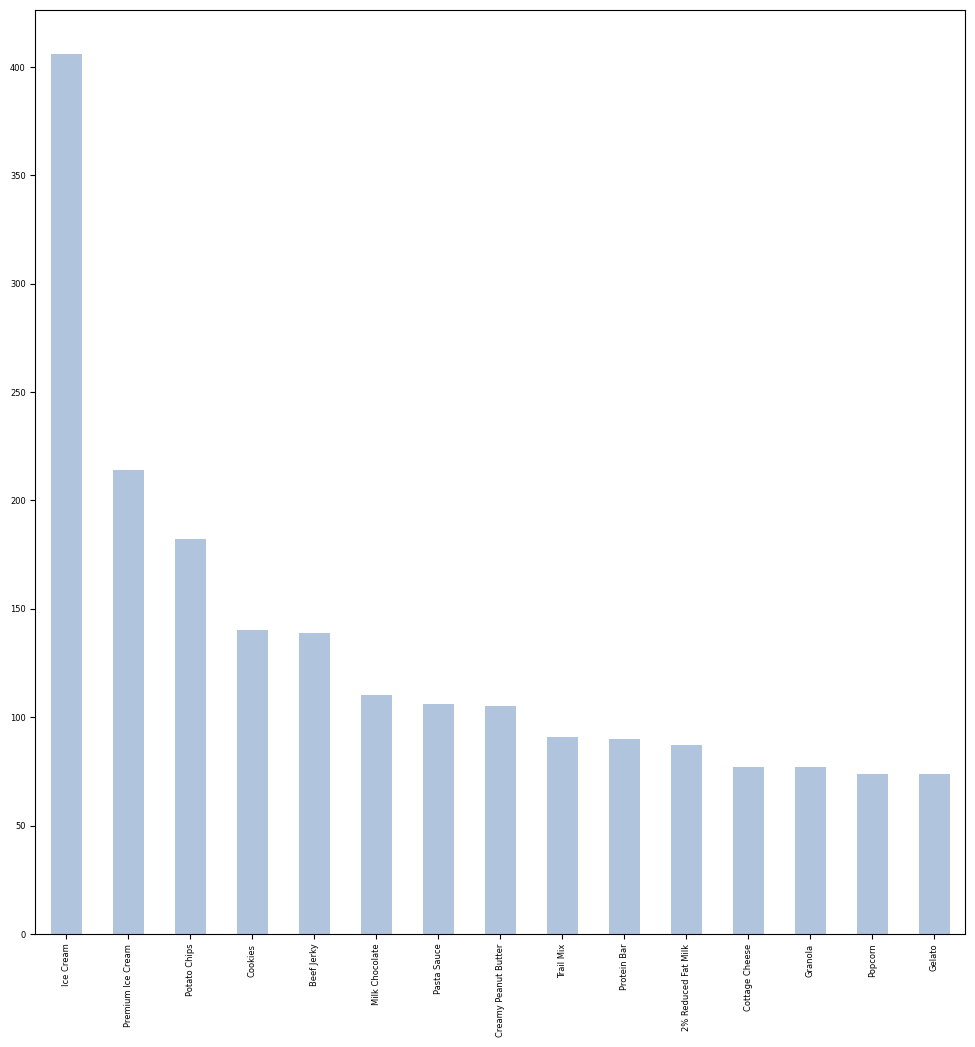

In [77]:
fig = sampling_open_food_job['product_name'].value_counts().head(15).plot.bar(color='lightsteelblue')

In [78]:
# Sauvegarde des graphiques en format "png"
fig.figure.savefig("./export/img/030_open_food_valeurs_noms_produits.png", dpi=300, bbox_inches='tight')

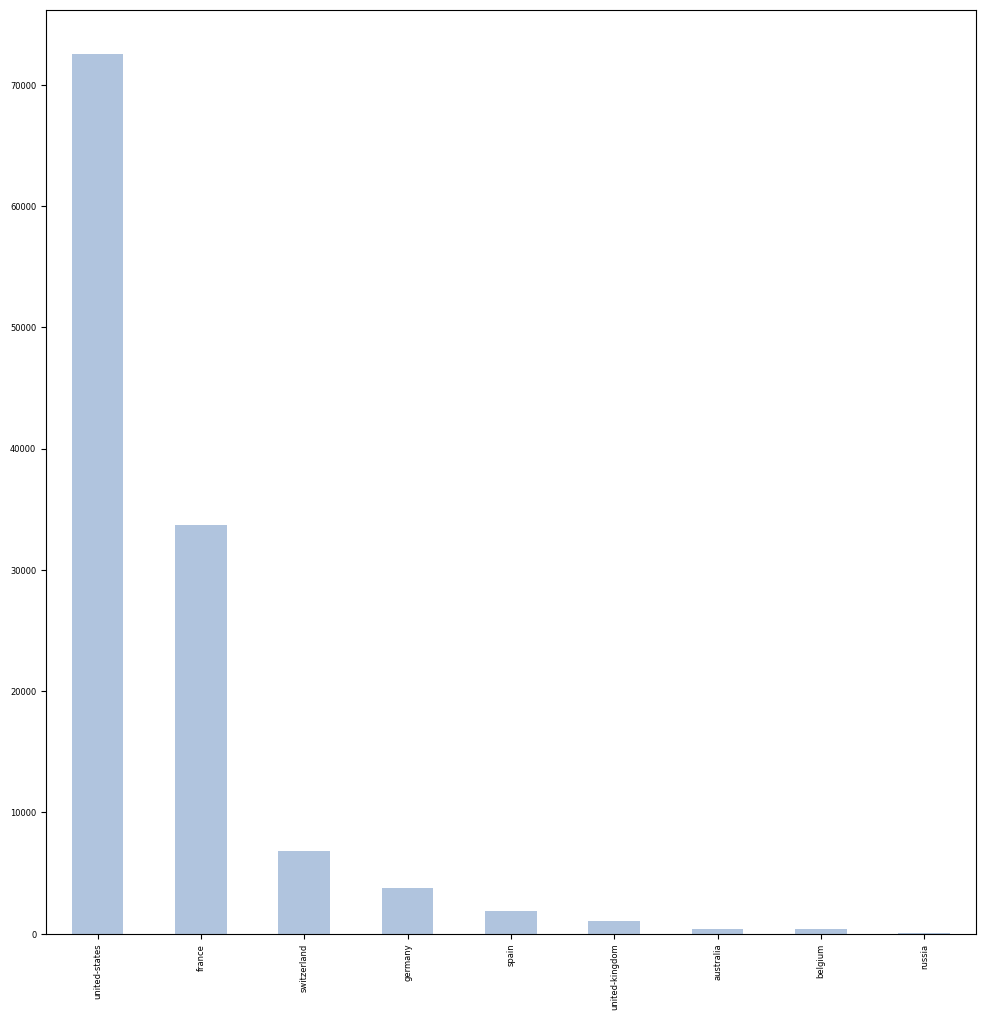

In [79]:
fig = sampling_open_food_job['countries_tags'].value_counts().head(9).plot.bar(color='lightsteelblue')

In [80]:
# Sauvegarde des graphiques en format "png"
fig.figure.savefig("./export/img/031_open_food_valeurs_noms_pays.png", dpi=300, bbox_inches='tight')

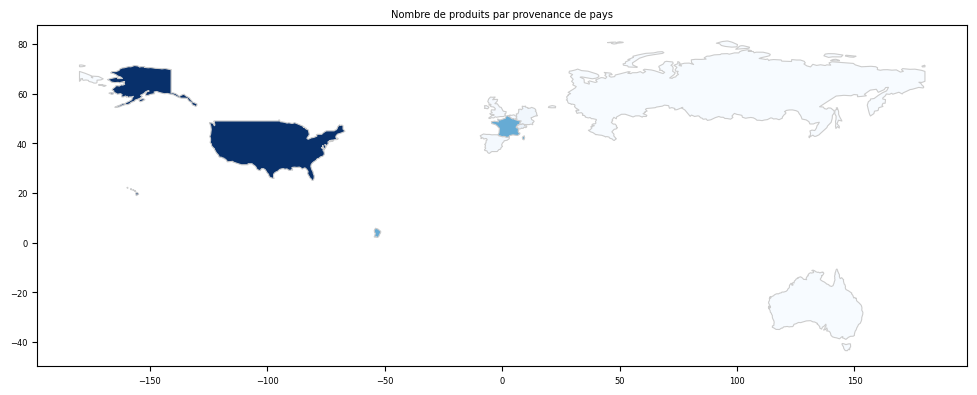

In [81]:
# Affichage univarié du nombre de produit pour les 9 Pays les plus représentés
# Charger les données géographiques pour les pays
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Créer un DataFrame avec les données de "Power" pour chaque pays
data = {'countries_fr': ['United States of America', 'France', 'Switzerland', 'Germany', 'Spain', 'United Kingdom', 'Belgium', 'Australia', 'Russia'],
        'Power': [168420, 87128, 12841, 7018, 4517, 3678, 1973, 1625, 1270]}
data = pd.DataFrame(data)

# Joindre les données de "Power" aux données géographiques pour les pays
merged = world.merge(data, left_on='name', right_on='countries_fr')

# Définir la colone "Power" comme la variable à utiliser pour la couleur de la carte
vmin, vmax = merged['Power'].min(), merged['Power'].max()

# Créer la carte
merged.plot(column='Power', cmap='Blues', linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax)

# Ajouter une légende
plt.title("Nombre de produits par provenance de pays")

# Exportation de l'image
plt.savefig("./export/img/032_open_food_number_of_products.png", dpi=300, bbox_inches='tight')

# Affichage
plt.show()

<h5>Valeurs numériques</h5>

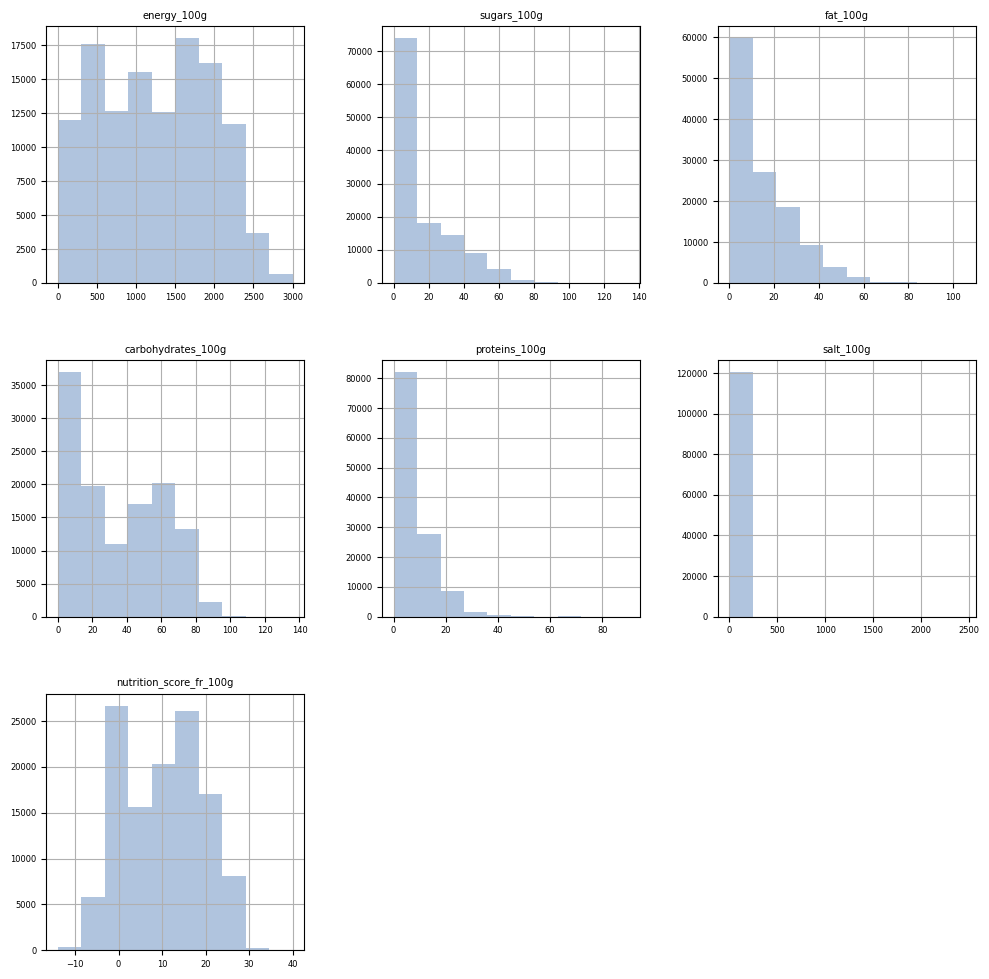

In [82]:
# Aperçu des valeurs des colonnes séléctionnés 
# ['energy_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']
sampling_open_food_job.loc[:,columns_float_selected].hist(color='lightsteelblue')
plt.savefig("./export/img/033_sampling_open_food_job_histogram_columns_float_selected.png", dpi=300, bbox_inches='tight')

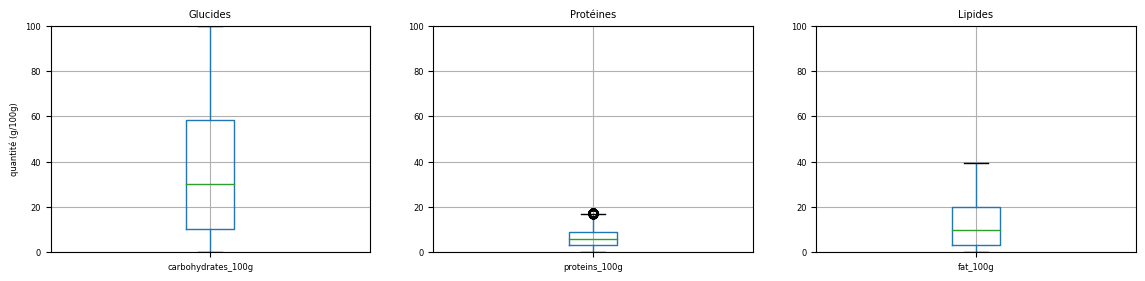

In [83]:
# Comparatif des valeurs de Glucides, Protéines et Lipides
plt.figure(3, figsize=(14, 10))

plt.subplot(331)
sampling_open_food_stat.boxplot(column='carbohydrates_100g')
plt.title('Glucides')
plt.ylabel('quantité (g/100g)')
plt.ylim(0,100)

plt.subplot(332)
sampling_open_food_stat.boxplot(column='proteins_100g')
plt.title('Protéines')
plt.ylim(0,100)

plt.subplot(333)
sampling_open_food_stat.boxplot(column='fat_100g')
plt.title('Lipides')
plt.ylim(0,100)

plt.savefig("./export/img/034_Glucides_Proteines_Lipides.png", dpi=300, bbox_inches='tight')
plt.show()


<h4>Analyse bi-variée</h4>

La fonction suivante effectue une analyse bi-variée car elle utilise deux variables distinctes, à savoir le grade Nutri-Score et le nombre de produits référencés.
Le graphique histogramme montre la distribution du Nutri-Score par grade, tandis que le graphique de boîte montre la répartition des scores pour chaque grade.

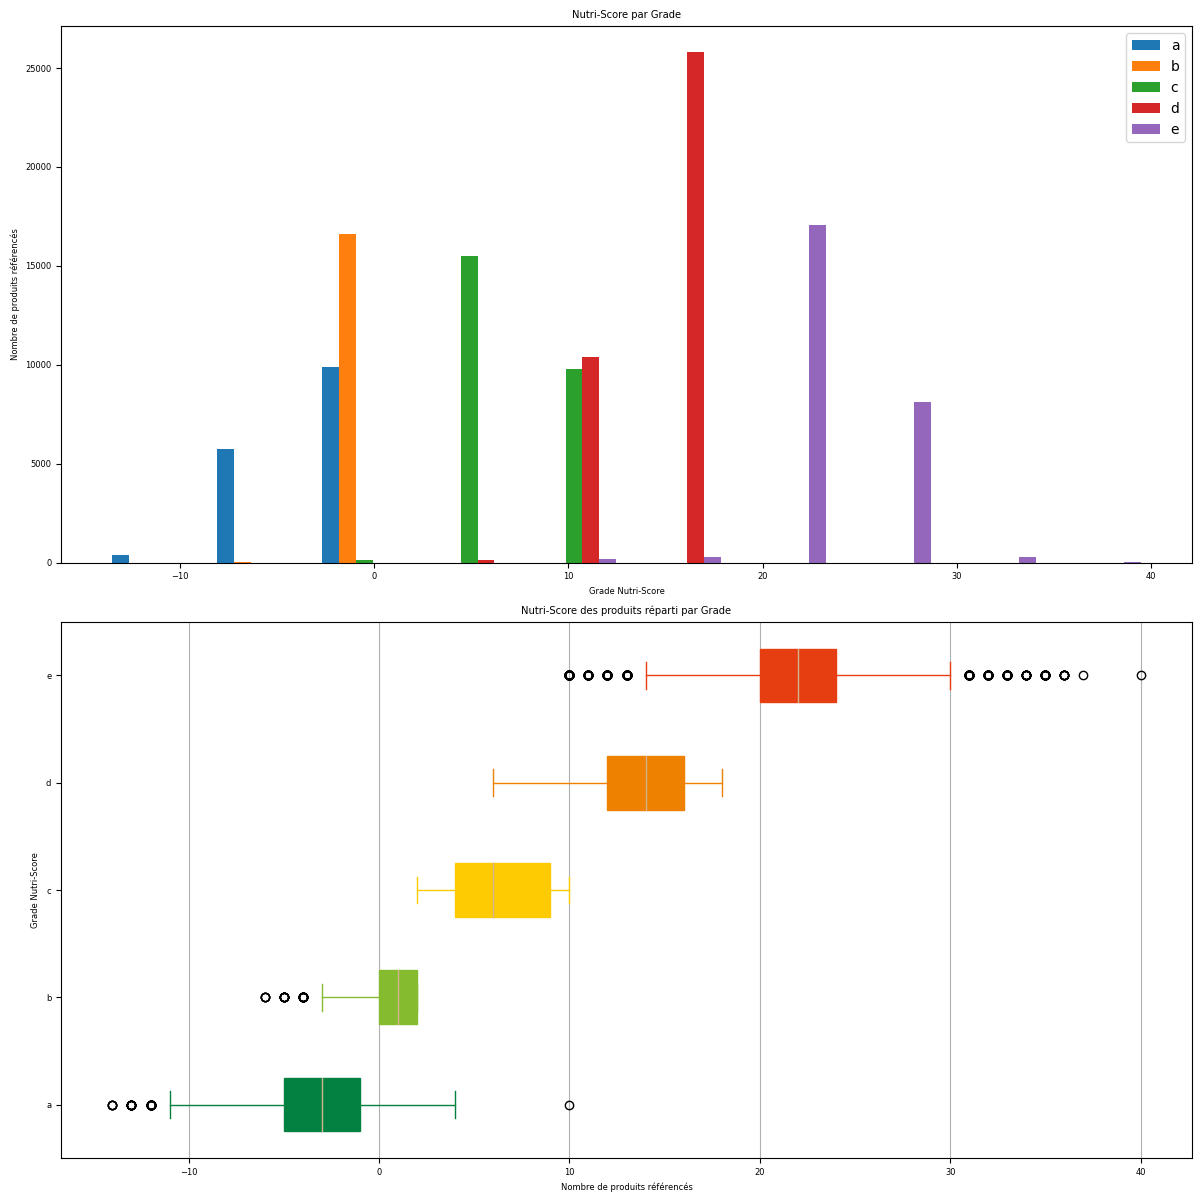

In [84]:
def plotScoreHistByGrade(df):

    # Jeu de couleur
    colors = ['#038141', '#85bb2f', '#fecb02', '#ee8100', '#e63e11', '#038141', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']
    df_colors = pd.DataFrame(colors, columns=['colors'])
    
    grades = sorted(list(df['nutrition_grade_fr'].dropna().unique()))
    lst_grade = [df[df['nutrition_grade_fr'] == grd]['nutrition_score_fr_100g'] for grd in grades]

    # Graphique à deux entrées
    fig, axes = plt.subplots(nrows=2, ncols=1)
    ax0, ax1 = axes.flatten()

    # 1 - histogramme
    ax0.hist(lst_grade, 10, histtype='bar', label=grades)
    ax0.legend(prop={'size': 10})
    ax0.set_xlabel('Grade Nutri-Score')
    ax0.set_ylabel('Nombre de produits référencés')
    ax0.set_title('Nutri-Score par Grade')

    # 2 - boxplot
    bp = ax1.boxplot(lst_grade, vert=False, patch_artist=True)
    ax1.xaxis.grid(True)
    ax1.set_xlabel('Nombre de produits référencés')
    ax1.set_ylabel('Grade Nutri-Score')
    ax1.set_title('Nutri-Score des produits réparti par Grade')
    plt.setp(ax1, yticklabels=grades)
    
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#038141', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']) 
    
    for elem_key, elem_val in bp.items():
        for idx, element in enumerate(elem_val):
            if elem_key == 'whiskers' or elem_key == 'caps':
                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx//2]
            else:
                color = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx]
            if elem_key == 'boxes':
                element.set(edgecolor=color)
                element.set(facecolor=color)
            elif elem_key == 'medians':
                element.set(color='tan')
            else:
                element.set(color=color)

    # Affichage
    fig.tight_layout()
    
    # Enregistrement de la figure dans un fichier image
    plt.savefig("./export/img/035_nutriscore.png", dpi=300, bbox_inches='tight')
    
    # Affichage
    plt.show()
    
# plotScoreHistByGrade(sampling_open_food_copy)
plotScoreHistByGrade(sampling_open_food_job)
# plotScoreHistByGrade(sampling_open_food_stat)

<h4>Analyse multivariée</h4>

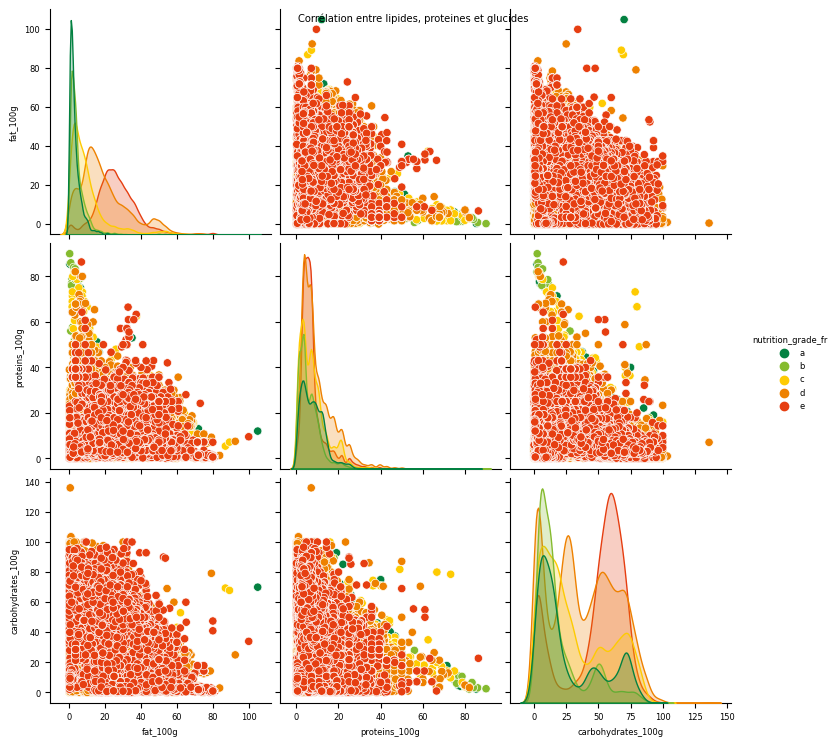

In [85]:
# ['energy_100g', 'sugars_100g', 'salt_100g', 'nutrition-score-fr_100g']

# Ce tri est nécessaire pour afficher les variables et la légende dans l'ordre
df_sort = sampling_open_food_job.sort_values(by='nutrition_grade_fr', axis='index')

pp = sns.pairplot(df_sort.loc[:,['fat_100g', 'proteins_100g', 'carbohydrates_100g', 'nutrition_grade_fr']], hue='nutrition_grade_fr')

fig = pp.fig
fig.suptitle('Corrélation entre lipides, proteines et glucides')

fig_copy = fig.get_figure()
fig_copy.savefig("./export/img/036_croisement_nutri-score.png", dpi=300, bbox_inches='tight')


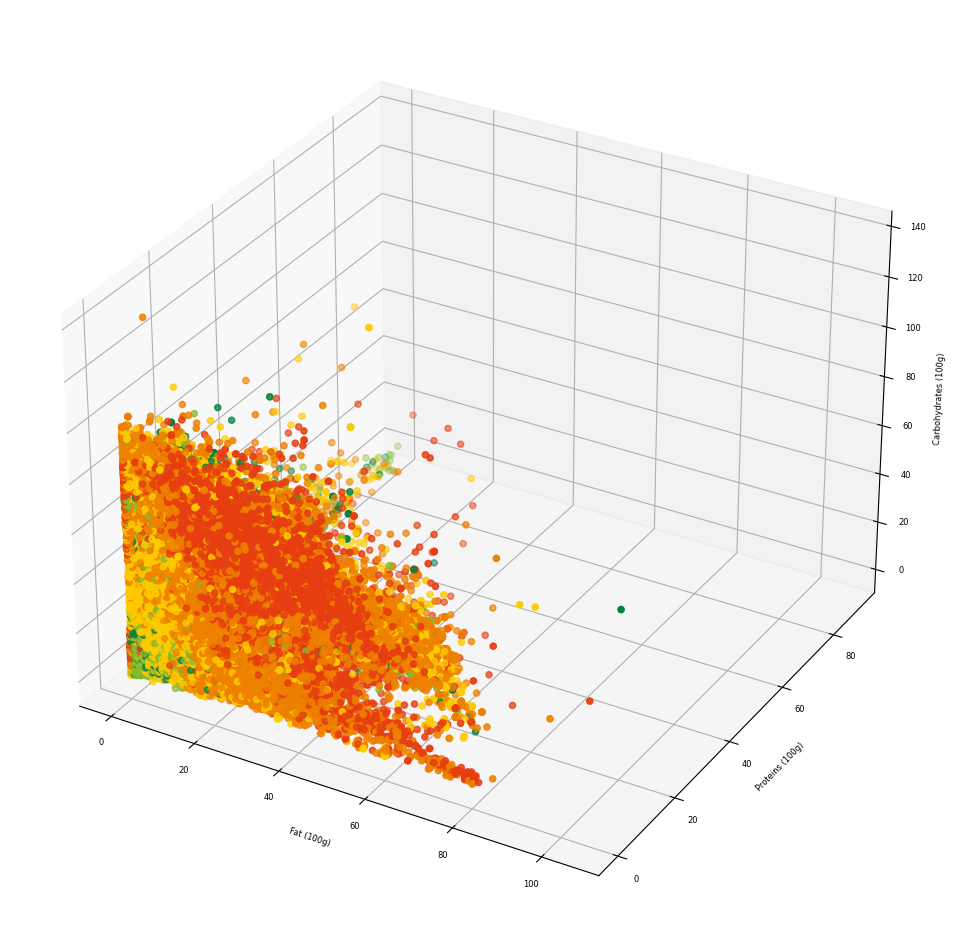

In [86]:
from mpl_toolkits.mplot3d import Axes3D

colors = {'a': '#038141', 'b': '#85bb2f', 'c': '#fecb02', 'd': '#ee8100', 'e': '#e63e11'}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df_sort['fat_100g']
y = df_sort['proteins_100g']
z = df_sort['carbohydrates_100g']
c = [colors[val] for val in df_sort['nutrition_grade_fr']]

ax.scatter(x, y, z, c=c)

ax.set_xlabel('Fat (100g)')
ax.set_ylabel('Proteins (100g)')
ax.set_zlabel('Carbohydrates (100g)')

# Enregistrement de la figure dans un fichier image
plt.savefig("./export/img/037_trio_3d.png", dpi=300, bbox_inches='tight')

plt.show()

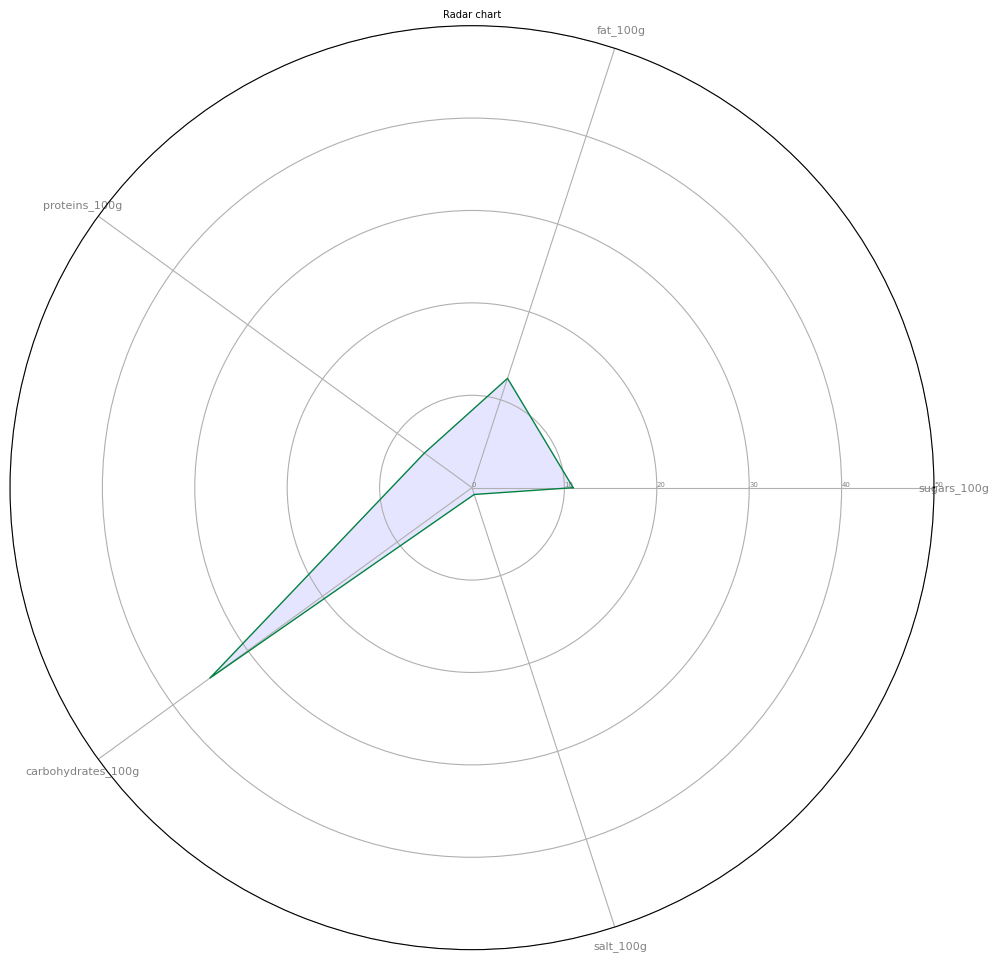

In [87]:
# Sélectionner les champs de type float à utiliser pour l'analyse exploratoire
fields = ['sugars_100g', 'fat_100g', 'proteins_100g', 'carbohydrates_100g', 'salt_100g'] # 'energy_100g', 
# fields = columns_float_selected

# Sélectionner les colonnes à utiliser pour l'analyse exploratoire
X = sampling_open_food_stat[fields]

# Remplacer les valeurs manquantes par la moyenne des valeurs
# X = X.fillna(X.mean())

#Créer un Radar chart
categories= fields

N = len(categories)

values = X.mean().values.flatten().tolist()
values += values[:1]

angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories, color='grey', size=8)

ax.set_rlabel_position(0)
plt.yticks([0,10,20,30,40,50], ["0","10","20","30","40","50"], color="grey", size=5)
plt.ylim(0,50)

ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)

plt.title("Radar chart")

# Enregistrement de la figure dans un fichier image
plt.savefig("./export/img/038_radar_chart.png", dpi=300, bbox_inches='tight')

plt.show()

<h4>ACP</h4>

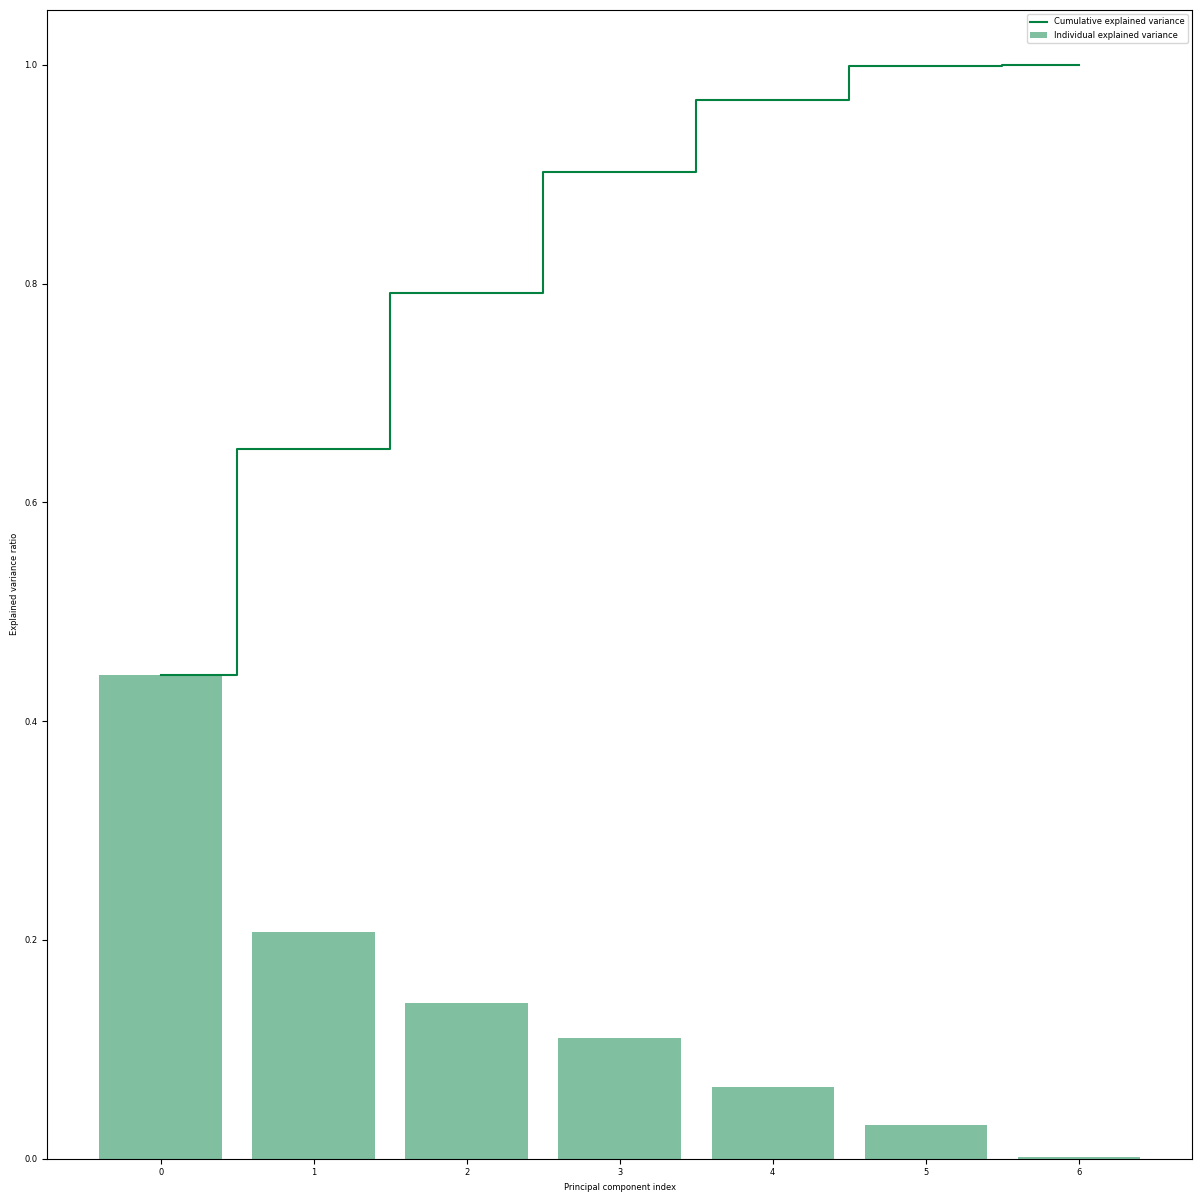

In [88]:
# Importation des librairies utiles pour réaliser l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataframe_selected = sampling_open_food_job[columns_float_selected]
dataframe_selected_test = sampling_open_food_job[columns_float_selected]

sc = StandardScaler()
sc.fit(dataframe_selected)

dataframe_selected_std = sc.transform(dataframe_selected)
dataframe_selected_test_std = sc.transform(dataframe_selected_test)

# Création / Instanciation du PCA
pca = PCA()

# 
X_train_pca = pca.fit_transform(dataframe_selected_std)

# Déteminer le ratio de l'ACP
exp_var_pca = pca.explained_variance_ratio_

# Somme cumulative
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Affichage de type plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

# Enregistrement de la figure dans un fichier image
plt.savefig("./export/img/039_ACP_proportionnalité.png", dpi=300, bbox_inches='tight')

plt.show()

In [89]:
exp_var_pca

array([0.44198907, 0.20712569, 0.14260345, 0.11008908, 0.06585109,
       0.03074317, 0.00159845])

L'analyse de composante principale (ACP ou PCA) est une technique utilisée pour explorer les relations entre plusieurs variables quantitatives. Elle permet de réduire la dimensionnalité des données en regroupant les variables les plus corrélées en composantes principales.

In [90]:
def pca_map(pca, columns, cp1, cp2, figsize=(10,10), sup="", print_values= False):
    # PCA
    pca_values=pca.components_
    
    # Plot
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 14}) 
    
    # Plot circle
    x=np.linspace(start=-1,stop=1,num=500)
    y_positive=lambda x: np.sqrt(1-x**2) 
    y_negative=lambda x: -np.sqrt(1-x**2)
    plt.plot(x,list(map(y_positive, x)), color='maroon')
    plt.plot(x,list(map(y_negative, x)),color='maroon')
    
    # Plot smaller circle
    x=np.linspace(start=-0.5,stop=0.5,num=500)
    y_positive=lambda x: np.sqrt(0.5**2-x**2) 
    y_negative=lambda x: -np.sqrt(0.5**2-x**2)
    plt.plot(x,list(map(y_positive, x)), color='maroon')
    plt.plot(x,list(map(y_negative, x)),color='maroon')
    
    # Créer les lignes
    x=np.linspace(start=-1,stop=1,num=30)
    plt.scatter(x,[0]*len(x), marker='_',color='maroon')
    plt.scatter([0]*len(x), x, marker='|',color='maroon')

    # Définir une couleur pour chaque ligne
    colors = ['blue', 'red', 'green', 'black', 'purple', 'brown']
    if len(pca_values[cp1]) > 6:
        colors=colors*(int(len(pca_values[cp1])/6)+1)

    # 
    add_string=""
    for i in range(len(pca_values[cp1])):
        xi=pca_values[cp1][i]
        yi=pca_values[cp2][i]
        plt.arrow(0,0, 
                  dx=xi, dy=yi, 
                  head_width=0.03, head_length=0.03, 
                  color=colors[i], length_includes_head=True)
        if print_values==True:
            add_string=f" ({round(xi,2)} {round(yi,2)})"
        plt.text(pca_values[cp1, i], 
                 pca_values[cp2, i] , 
                 s=columns[i] + add_string )

    plt.xlabel(f"Component {cp1+1} ({round(pca.explained_variance_ratio_[cp1]*100,2)}%)")
    plt.ylabel(f"Component {cp2+1} ({round(pca.explained_variance_ratio_[cp2]*100,2)}%)")
    plt.title('Analyse en composantes principales (ACP)')
    plt.suptitle(sup, y=1, fontsize=18)
    
    # Enregistrement de la figure dans un fichier image
    plt.savefig("./export/img/040_ACP_composantes_principales.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    


L'ACP peut être utilisée pour visualiser les données, identifier les groupes de variables les plus importants et pour prévoir les relations entre les variables.

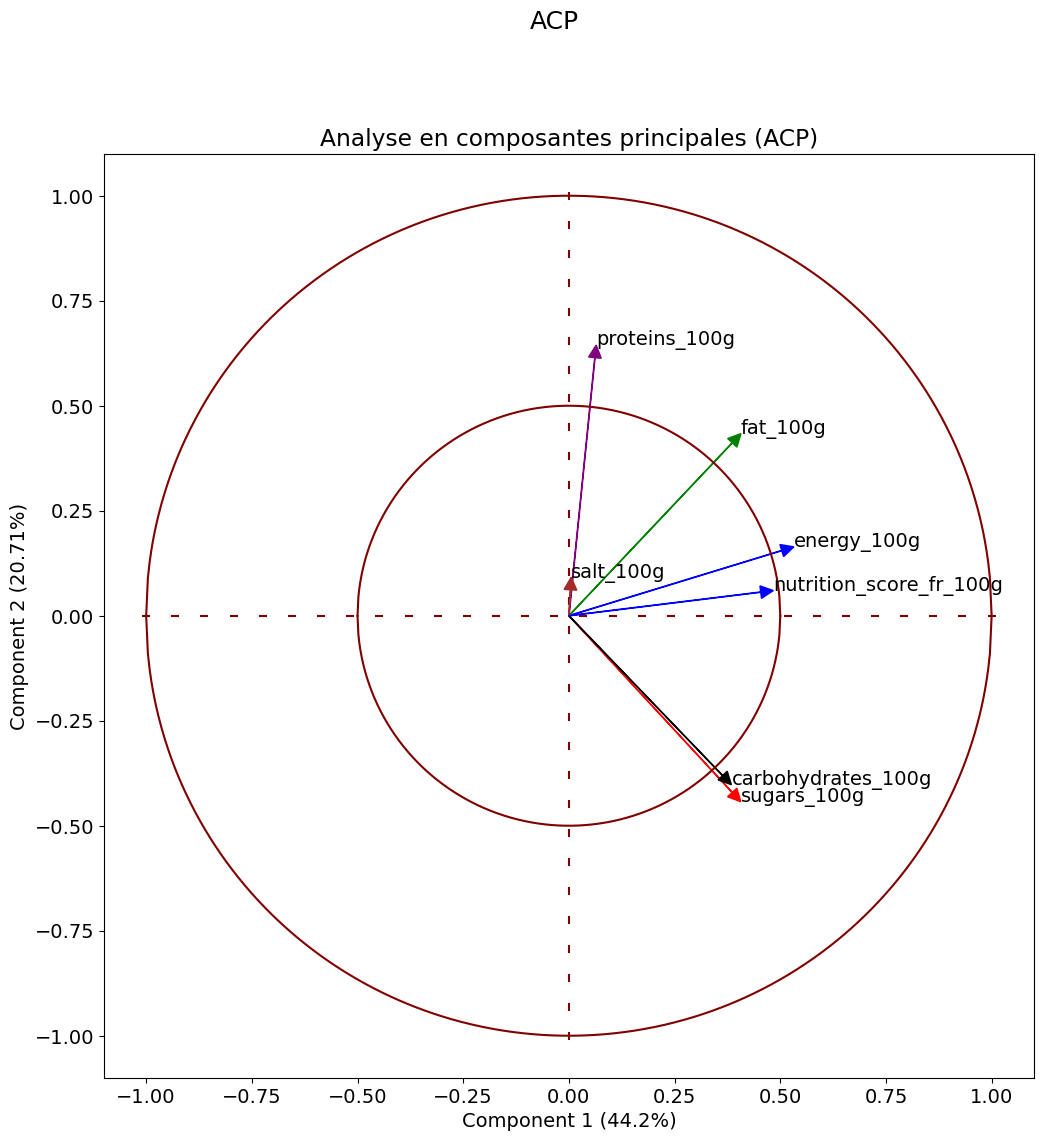

In [91]:
# sampling_open_food_job[columns_float_selected]
X=pd.DataFrame(data=sampling_open_food_job,columns=columns_float_selected)

pca_map(pca, X.columns.values, cp1=0, cp2=1, figsize=(12,12), sup="ACP")

Le coefficient de corrélation de la variable 'energy_100g' avec la première dimension est significatif (angle de 90 degrés).

Les coefficients de corrélation des autres variables avec la deuxième dimension sont positifs ou négatifs, ce qui signifie qu'une augmentation de la valeur de ces variables sera associée à une augmentation ou à une diminution de la valeur de la deuxième dimension.

In [92]:
# scatterplot individus

<h4>ANOVA</h4>

In [93]:
import scipy.stats as stats

# Sélectionner les colonnes nécessaires
# ['product_name', 'brands', 'countries_tags', 'ingredients_text', 'nutrition_grade_fr', 'main_category_fr']
# ['energy_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'nutrition_score_fr_100g']

# Chargement des données
data = sampling_open_food_job

# Sélectionner les colonnes à utiliser pour l'analyse ANOVA
grouped = data.groupby(["main_category_fr"])["nutrition_score_fr_100g"]
groups = [group[1] for group in grouped]

# Effectuer un test ANOVA
f_value, p_value = stats.f_oneway(*groups)

# Analyse des résultats
if p_value < 0.05:
    print("Il y a une différence significative entre les groupes de catégories alimentaires en termes de scores nutritionnels")
else:
    print("Il n'y a pas de différence significative entre les groupes de catégories alimentaires en termes de scores nutritionnels")


Il y a une différence significative entre les groupes de catégories alimentaires en termes de scores nutritionnels


In [94]:
# Sélectionner les colonnes à utiliser pour l'analyse ANOVA
grouped = data.groupby(["brands"])["sugars_100g"]
groups = [group[1] for group in grouped]

# Effectuer un test ANOVA
f_value, p_value = stats.f_oneway(*groups)

# Analyse des résultats
if p_value < 0.05:
    print("Il y a une différence significative entre les marques en termes de teneur en sucre")
else:
    print("Il n'y a pas de différence significative entre les marques en termes de teneur en sucre")

Il y a une différence significative entre les marques en termes de teneur en sucre


In [95]:
# Sélectionner les colonnes à utiliser pour l'analyse ANOVA
grouped = data.groupby(["main_category_fr"])["sugars_100g"]
groups = [group[1] for group in grouped]

# Effectuer un test ANOVA
f_value, p_value = stats.f_oneway(*groups)

# Analyse des résultats
if p_value < 0.05:
    print("Il y a une différence significative entre les catégories en termes de teneur en sucre")
else:
    print("Il n'y a pas de différence significative entre les catégories en termes de teneur en sucre")

Il y a une différence significative entre les catégories en termes de teneur en sucre


<h3>Exportation des données</h3>

In [96]:
# Sauvegarde de l'échantillonnage de données
sampling_open_food_stat.to_csv('./export/csv/sampling_open_food_stat.csv', sep='\t')